# Debiasing Synthetic Data Generated by Deep Generative Models

Results of the simulation study in "Debiasing Synthetic Data Generated by Deep Generative Models", presented during the 38th Annual Conference on Neural Information Processing Systems.

**(c) SYNDARA**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import plotnine
from plotnine import *
import networkx as nx
from utils.disease import ground_truth
from utils.eval import missing_se, plot_bias, plot_nuisance_parameters, plot_ic_se, plot_compare_se, plot_convergence_rate, table_convergence_rate, summary_table, plot_coverage, plot_type_I_II_error

## Data generating process

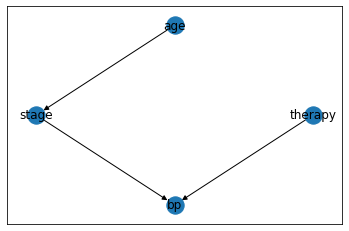

In [3]:
dag = nx.DiGraph()
dag.add_edges_from([('age', 'stage'), ('stage', 'bp'), ('therapy', 'bp')])
fixed_positions = {'age':(0.5,0), 'stage':(0,-1), 'bp':(0.5,-2), 'therapy':(1,-1)}
fixed_nodes = fixed_positions.keys()
pos = nx.spring_layout(dag, pos=fixed_positions, fixed=fixed_nodes)
nx.draw_networkx(dag, pos, arrows=True)

## Load meta data

In [4]:
sim_dir = 'simulation_study1/'
meta_data = pd.read_csv(sim_dir + 'meta_data.csv')
meta_diagnostics = pd.read_csv(sim_dir + 'meta_diagnostics.csv')
meta_diagnostics2 = pd.read_csv(sim_dir + 'meta_diagnostics2.csv')

In [5]:
data_gt, data_rescale = ground_truth()

## Inspect meta data

In [6]:
meta_data.shape

(11140, 48)

CTGAN (Synthcity) could not be trained in 14 runs (runs 38, 69, 102, 225 for  = 500; runs 19, 23, 98, 107, 117, 128, 129, 140, 148, 169 for n = 5000) due to an internal error in he package. As such, it was not possible to generate default and debiased synthetic data with CTGAN (Synthcity) in these runs. This comprises 1.12% (14/1250) of all CTGAN (Synthcity) trained and 0.28% (14/5000) of all generators trained. The other generative models did not produce errors uring training, so that default synthetic data could be generated in every run.

TVAE (SDV) could not be targeted in 82 runs (runs 1, 3, 4, 5, 6, 8, 5, 23, 24, 28, 30, 42, 46, 50, 51, 58, 64, 72, 78, 92, 96, 104, 106, 111, 112, 117, 118, 119, 122, 126, 127, 130, 133, 135, 140, 143, 146, 149, 154, 157, 159, 160, 166, 167, 168, 170, 178, 180, 187, 191, 193, 196, 197, 200, 205, 210, 214, 216, 218, 220, 225, 230, 231, 235, 236, 245, 247, 248 for n = 50; runs 13, 22, 97, 117, 139, 145, 146, 148, 161, 186, 193, 197, 235, 246 for n = 160) due to sparse data, especially for small sample sizes. In particular, some Xi in the original dataset may not be present in the default synthetic dataset generated by TVAE (SDV), leading to an error when estimating the nuisance parameters needed for the debiasing step. This comprises 6.56% (82/1250) of all TVAE (SDV) trained and 1.64% (82/5000) of all generators trained. The other generative models did not produce errors during targeting, so that debiased synthetic data could be generated in every run.

-> 5 sample sizes, 250 Monte Carlo runs, 1 original dataset, 4 generative models with 2 synthetic datasets per model, so 5x250x(1+4x2)=11250 datasets. 
-> 14 failed generators: 14 default and 14 debiased synthetic datasets
-> 82 failed targeting: 82 datasets
-> 11250-14-14-82=11140

In [7]:
meta_data.head()

dataset_name   n    run              generator   age_mean  \
0           custom_ctgan_0  50  run_0           custom_ctgan  47.704687   
1                   tvae_0  50  run_0                   tvae  53.268398   
2  custom_ctgan_targeted_0  50  run_0  custom_ctgan_targeted  51.283321   
3                  ctgan_0  50  run_0                  ctgan  53.038610   
4          tvae_targeted_0  50  run_0          tvae_targeted  49.706201   

   age_mean_se  age_meanic  age_meanic_se  bp_stage_II_ols  bp_stage_III_ols  \
0     1.736228   47.704687       1.736228        -1.012093         -3.841441   
1     0.955776   53.268398       0.955776        -0.141885         -0.180377   
2     1.736228   51.283321       1.736228         2.271224         -0.737097   
3     1.324210   53.038610       1.324210        -7.584068         19.759761   
4     0.955776   49.706201       0.955776         0.555037         -0.068544   

   ...  bp_therapy_ols_NHST_type1_corrected  bp_therapy_ols_NHST_type2  \
0  ...                                False                       True   
1  ...                                 True                      False   
2  ...                                False                       True   
3  ...                                False                       True   
4  ...                                False                       True   

   bp_therapy_ols_NHST_type2_corrected  bp_therapy_olsic_bias  \
0                                 True             -58.209877   
1                                False              12.173884   
2                                 True             -78.414237   
3                                 True               1.530607   
4                                 True              -2.162664   

   bp_therapy_olsic_coverage  bp_therapy_olsic_coverage_corrected  \
0                       True                                 True   
1                      False                                False   
2                      False                                 True   
3                       True                                 True   
4                       True                                 True   

   bp_therapy_olsic_NHST_type1  bp_therapy_olsic_NHST_type1_corrected  \
0                        False                                  False   
1                         True                                   True   
2                         True                                  False   
3                        False                                  False   
4                        False                                  False   

   bp_therapy_olsic_NHST_type2  bp_therapy_olsic_NHST_type2_corrected  
0                         True                                   True  
1                        False                                  False  
2                        False                                   True  
3                         True                                   True  
4                         True                                   True  

[5 rows x 48 columns]

## Missing estimates

Due to sparse data, especially for small sample sizes, some estimators could not be estimated in a small subset of the (original and synthetic) datasets, producing extremely small (< 1e−10) or large (> 1e2) standard errors. In particular, estimates for the standard error based on the *influence curve* could not be obtained in 2.54% (283/11140), mainly for *m* = *n* = 50 and to a much lesser extent for *m* = *n* = 160 and *m* = *n* = 500, due to the cross-fitting procedure for EIC-based estimators (some Xi in the validation set may not be present in the training set on which the nuisance parameters E_hat_Y_given_X and E_hat_A_given_X are calculated).

In [8]:
data_missing = missing_se(meta_data)
order_columns = ['original', 'custom_ctgan', 'custom_ctgan_targeted', 'ctgan', 'ctgan_targeted', 
                 'custom_tvae', 'custom_tvae_targeted', 'tvae', 'tvae_targeted', 'All']

In [9]:
pd.crosstab(data_missing['estimator'], data_missing['n'], margins=True)

n                     50  160  500  All
estimator                              
bp_stage_III_ols_se  159   75    8  242
bp_stage_II_ols_se    99   65    8  172
bp_stage_IV_ols_se    68    4    0   72
bp_therapy_ols_se      8    2    0   10
bp_therapy_olsic_se  206   57   20  283
All                  540  203   36  779

In [10]:
pd.crosstab(data_missing['n'], data_missing['generator'], margins=True)

generator  ctgan  ctgan_targeted  custom_ctgan  custom_ctgan_targeted  \
n                                                                       
50            33              33            19                     19   
160            7               7             0                      0   
500            1               1             0                      0   
All           41              41            19                     19   

generator  custom_tvae  custom_tvae_targeted  original  tvae  tvae_targeted  \
n                                                                             
50                 232                   141         1    31             31   
160                105                    84         0     0              0   
500                 17                    17         0     0              0   
All                354                   242         1    31             31   

generator  All  
n               
50         540  
160        203  
500         36  
All        779

In [11]:
pd.crosstab(data_missing['estimator'], data_missing['generator'], margins=True)[order_columns]

generator            original  custom_ctgan  custom_ctgan_targeted  ctgan  \
estimator                                                                   
bp_stage_III_ols_se         0             0                      0     11   
bp_stage_II_ols_se          0             0                      0      3   
bp_stage_IV_ols_se          0             0                      0      6   
bp_therapy_ols_se           0             4                      4      1   
bp_therapy_olsic_se         1            15                     15     20   
All                         1            19                     19     41   

generator            ctgan_targeted  custom_tvae  custom_tvae_targeted  tvae  \
estimator                                                                      
bp_stage_III_ols_se              11          125                    77     9   
bp_stage_II_ols_se                3          103                    61     1   
bp_stage_IV_ols_se                6           31                    21     4   
bp_therapy_ols_se                 1            0                     0     0   
bp_therapy_olsic_se              20           95                    83    17   
All                              41          354                   242    31   

generator            tvae_targeted  All  
estimator                                
bp_stage_III_ols_se              9  242  
bp_stage_II_ols_se               1  172  
bp_stage_IV_ols_se               4   72  
bp_therapy_ols_se                0   10  
bp_therapy_olsic_se             17  283  
All                             31  779

In [12]:
pd.crosstab(data_missing.query('estimator==\'bp_therapy_ols_se\'')['n'], 
            data_missing.query('estimator==\'bp_therapy_ols_se\'')['generator'], margins=True)

generator  ctgan  ctgan_targeted  custom_ctgan  custom_ctgan_targeted  All
n                                                                         
50             0               0             4                      4    8
160            1               1             0                      0    2
All            1               1             4                      4   10

## Average IKLD

In [13]:
order_generators = ['custom_ctgan', 'custom_ctgan_targeted', 'ctgan', 'ctgan_targeted',
                    'custom_tvae', 'custom_tvae_targeted', 'tvae', 'tvae_targeted']
meta_data.groupby(['n', 'generator'])['sanity_IKLD'].mean().reset_index().melt(
    id_vars=['n', 'generator'],
    var_name='estimator',
    value_name='IKLD').pivot(index='generator', columns='n', values='IKLD').loc[order_generators].style.format(precision=3)

## Coverage

**Plot (main text)**

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'color' is already present.
Adding another scale for 'color',
which will replace the existing scale.

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'linetype' is already present.
Adding another scale for 'linetype',
which will replace the existing scale.



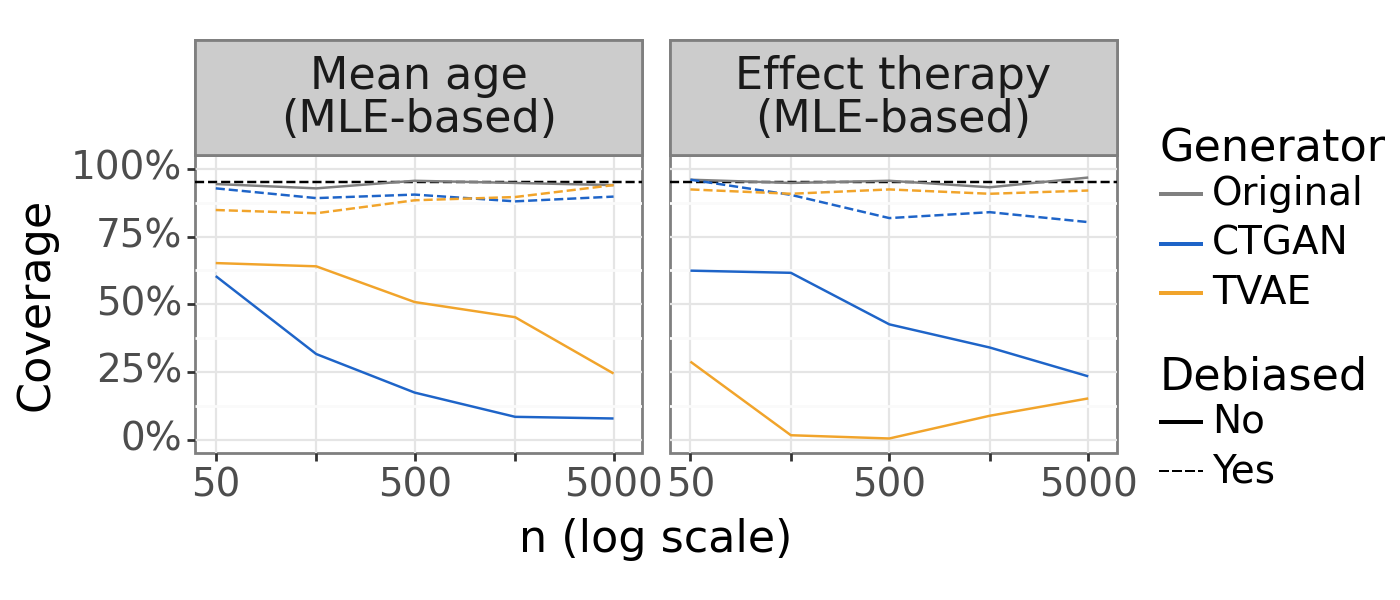

<Figure Size: (700 x 300)>

In [14]:
# Relabel
relabel_estimators = {'age_mean': 'Mean age\n(MLE-based)', 
                      'bp_therapy_ols': 'Effect therapy\n(MLE-based)'}
# Plot
coverageplot_main = plot_coverage(meta_data.query('generator not in [\'custom_ctgan\', \'custom_ctgan_targeted\', \'custom_tvae\', \'custom_tvae_targeted\']'),
                                  select_estimators=['age_mean', 'bp_therapy_ols'],
                                  order_generators=['original', 'ctgan', 'tvae'],
                                  influence_curve=False,
                                  figure_size=(5.5,4)) +\
    facet_grid('. ~ estimator', scales='free', labeller=labeller(estimator=lambda x: relabel_estimators[x])) +\
    scale_x_continuous(limits=(50,5500), breaks=[50,160,500,1600,5000], labels=[50,'',500,'',5000], trans='log') +\
    scale_colour_manual(values={'original': '#808080', 'ctgan': '#1E64C8', 'tvae': '#F1A42B'}, # relabel legend                                                 
                        labels=['Original', 'CTGAN', 'TVAE']) +\
    scale_linetype_manual(values={'default': 'solid', 'targeted': 'dashed'}, # relabel legend  
                          labels=['No', 'Yes']) +\
    labs(colour='Generator', linetype='Debiased', y='Coverage') +\
    theme(aspect_ratio = 2/3,
          plot_title=element_blank(), # title size
          axis_title=element_text(size=16), # axis title size
          strip_text=element_text(size=16), # facet_grid title size
          panel_spacing=0.02, # add space between facets
          axis_text=element_text(size=14), # axis labels size
          legend_position='right',
          legend_title=element_text(size=16), # legend title size
          legend_title_align='left',
          legend_text=element_text(size=14), # legend labels size 
          legend_key=element_blank(),
          figure_size=(7,3))
coverageplot_main

In [15]:
#coverageplot_main.save(filename='plots/sim_coverage_main.pdf')

**Plots (appendix)**

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'color' is already present.
Adding another scale for 'color',
which will replace the existing scale.

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'linetype' is already present.
Adding another scale for 'linetype',
which will replace the existing scale.



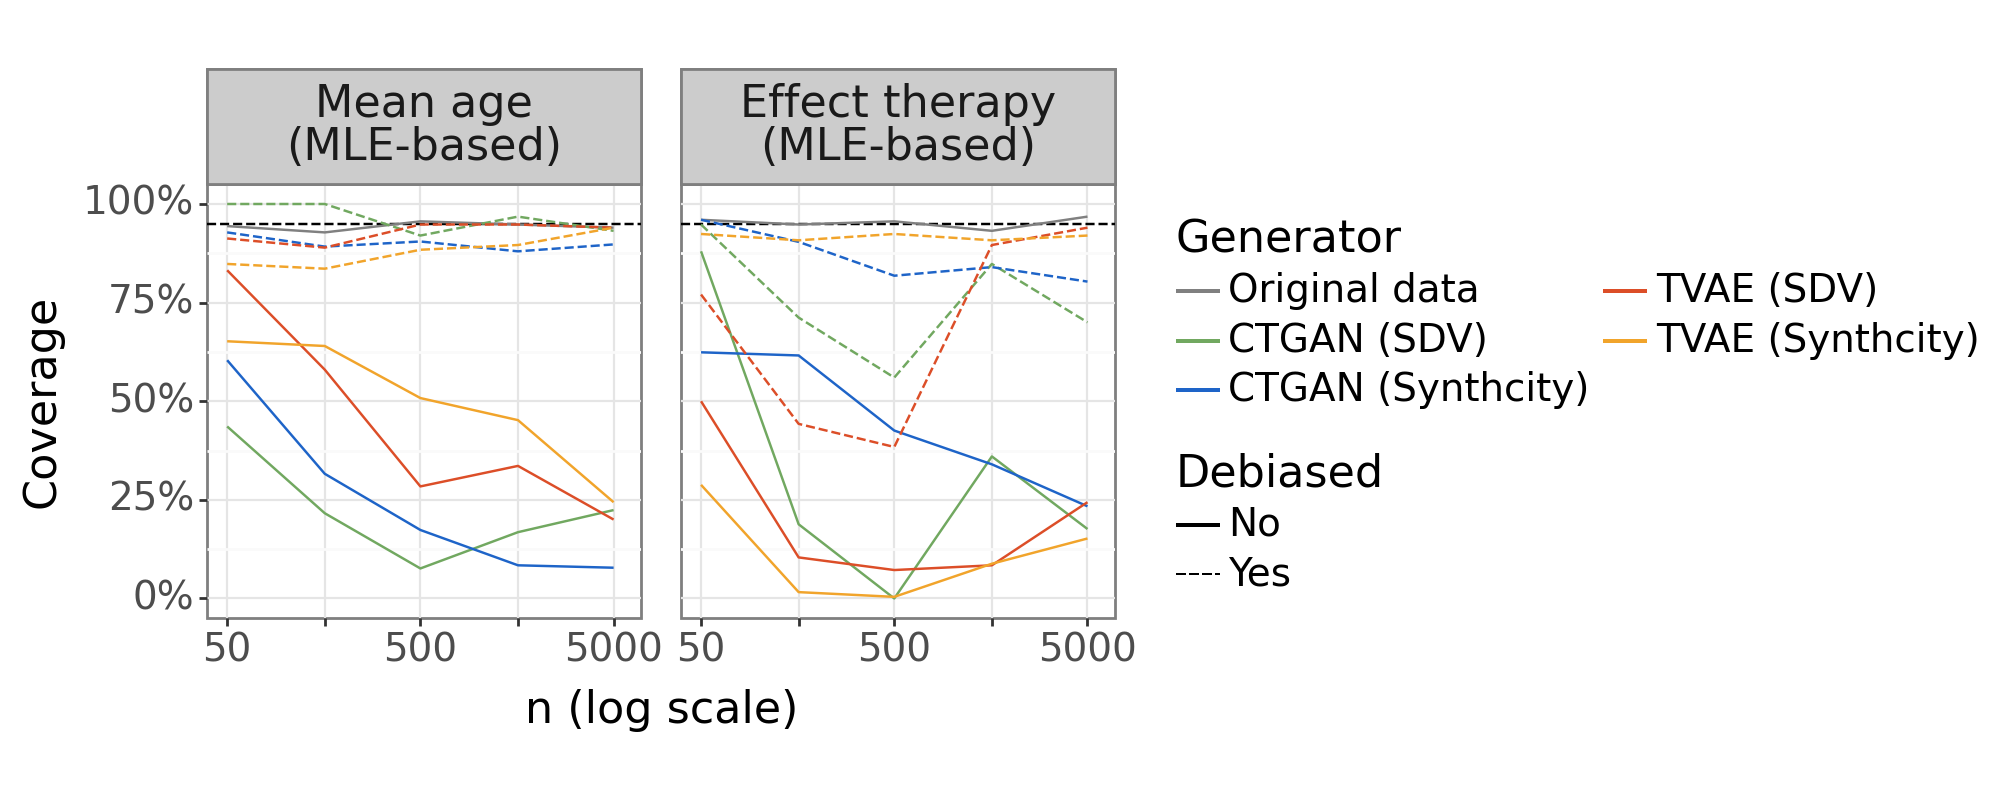

<Figure Size: (1000 x 400)>

In [29]:
# Relabel
relabel_estimators = {'age_mean': 'Mean age\n(MLE-based)', 
                      'bp_therapy_ols': 'Effect therapy\n(MLE-based)'}
# Plot
coverageplot_appendix = plot_coverage(meta_data, 
                                      select_estimators=['age_mean', 'bp_therapy_ols'],
                                      order_generators=['original', 'custom_ctgan', 'ctgan', 'custom_tvae', 'tvae'],
                                      influence_curve=False,
                                      figure_size=(10,4)) +\
    facet_grid('. ~ estimator', scales='free', labeller=labeller(estimator=lambda x: relabel_estimators[x])) +\
    scale_x_continuous(limits=(50,5500), breaks=[50,160,500,1600,5000], labels=[50,'',500,'',5000], trans='log') +\
    scale_colour_manual(values={'original': '#808080', 'custom_ctgan': '#71A860', 'ctgan': '#1E64C8', 'custom_tvae': '#DC4E28', 'tvae': '#F1A42B'}, # relabel legend                                                 
                        labels=['Original data', 'CTGAN (SDV)', 'CTGAN (Synthcity)', 'TVAE (SDV)', 'TVAE (Synthcity)']) +\
    scale_linetype_manual(values={'default': 'solid', 'targeted': 'dashed'}, # relabel legend  
                          labels=['No', 'Yes']) +\
    labs(colour='Generator', linetype='Debiased', y='Coverage') +\
    guides(colour=guide_legend(nrow=3),
           linetype=guide_legend(nrow=2)) +\
    theme(plot_title=element_blank(), # title size
          axis_title=element_text(size=16), # axis title size
          strip_text=element_text(size=16), # facet_grid title size
          panel_spacing=0.02, # add space between facets
          axis_text=element_text(size=14), # axis labels size
          legend_position='right',
          legend_title=element_text(size=16), # legend title size
          legend_title_align='left',
          legend_text=element_text(size=14), # legend labels size 
          legend_key=element_blank())
coverageplot_appendix

In [30]:
#coverageplot_appendix.save(filename='plots/sim_coverage_appendix.pdf')

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'color' is already present.
Adding another scale for 'color',
which will replace the existing scale.

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'linetype' is already present.
Adding another scale for 'linetype',
which will replace the existing scale.



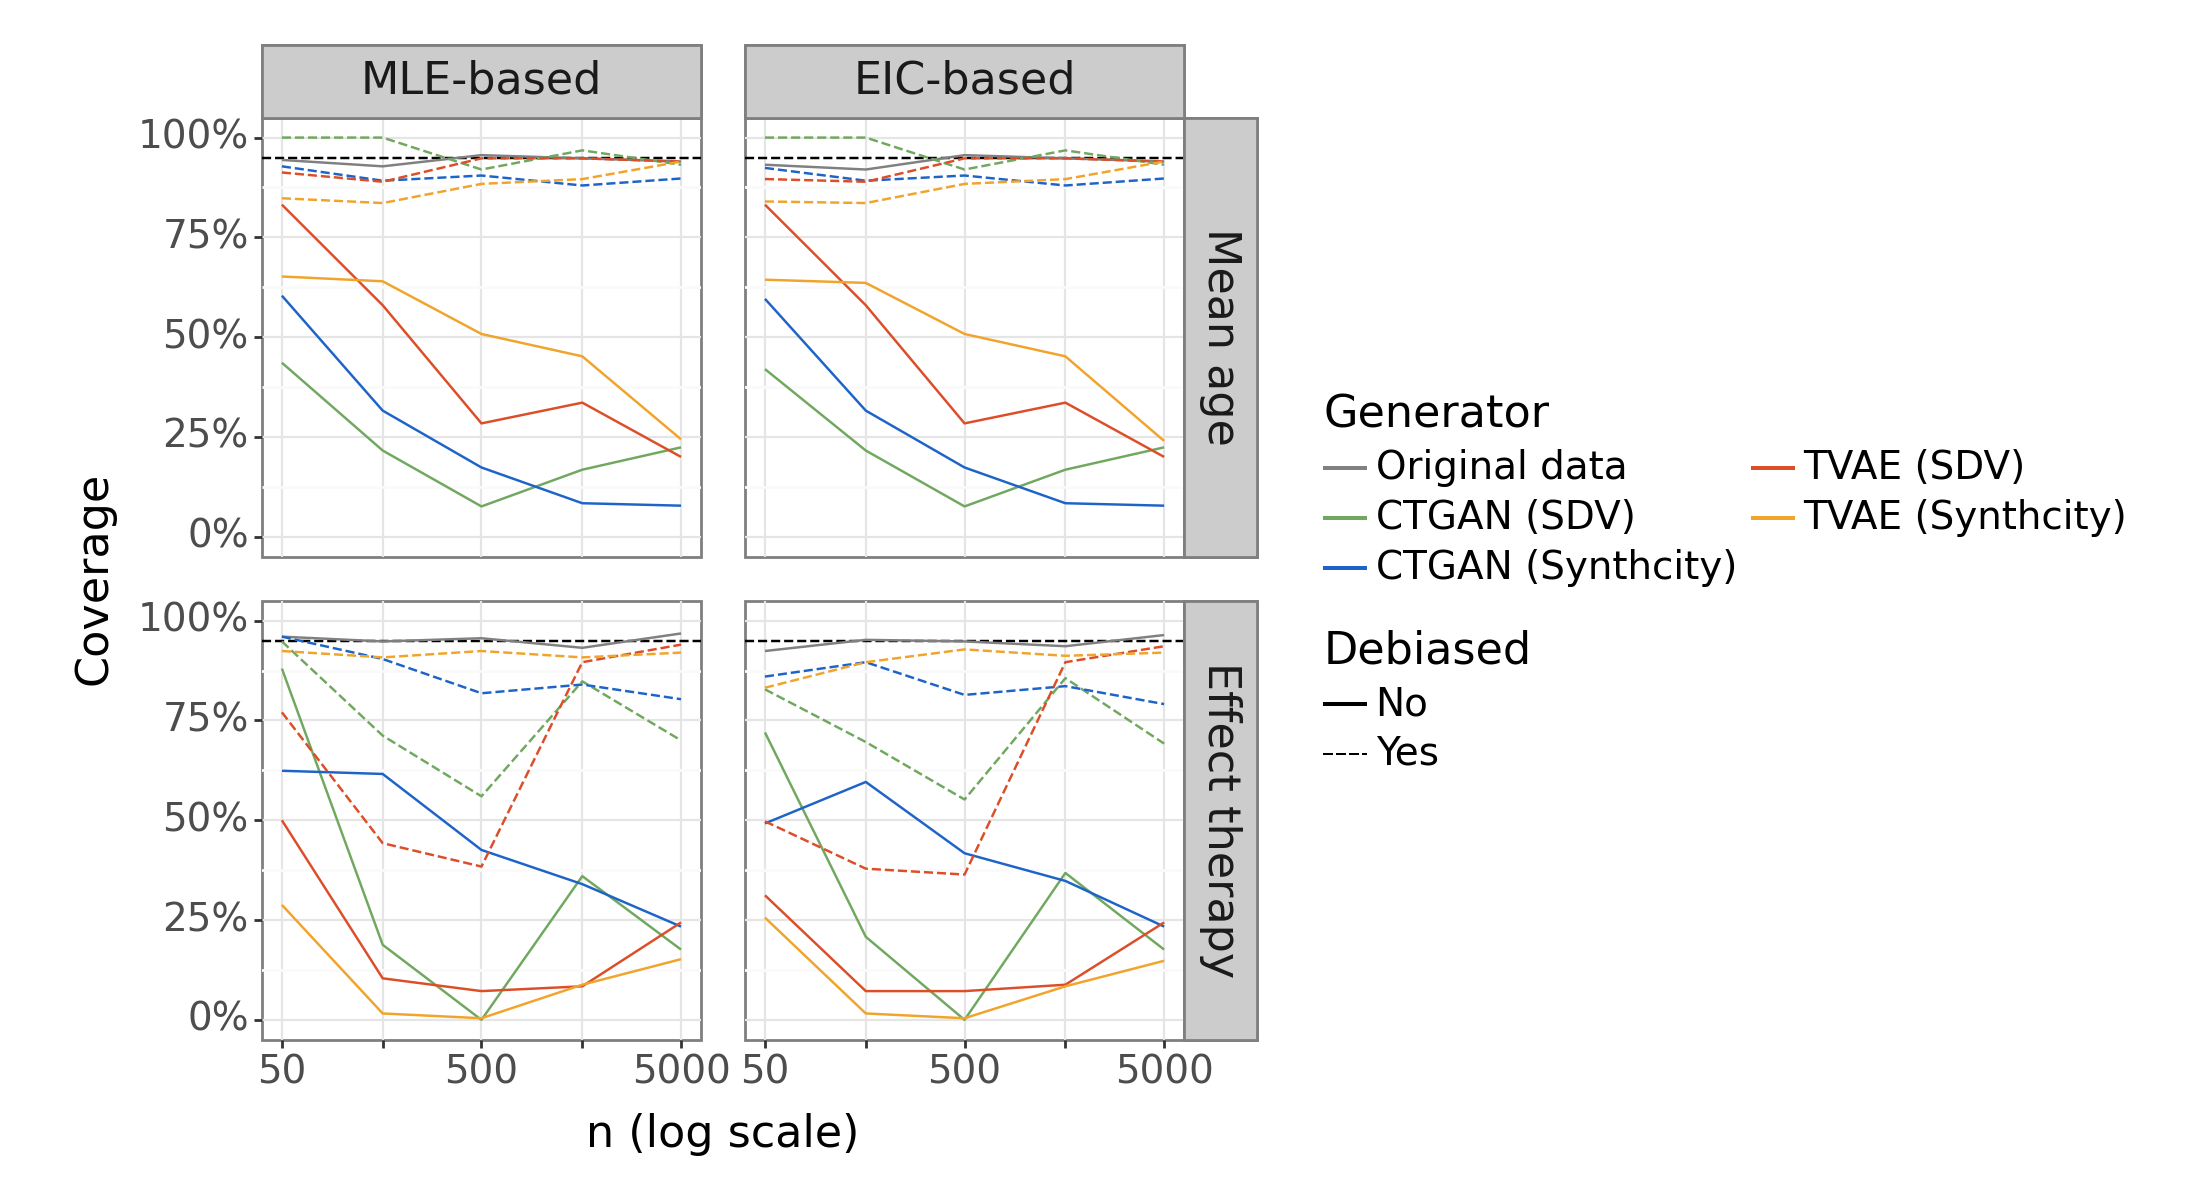

<Figure Size: (1100 x 600)>

In [31]:
# Relabel
relabel_estimators = {'age_mean': 'Mean age', 
                      'bp_therapy_ols': 'Effect therapy'}
relabel_se = {'model_based': 'MLE-based',
              'ic': 'EIC-based'}

# Plot
coverageplot_ic = plot_coverage(meta_data, 
                                select_estimators=['age_mean', 'bp_therapy_ols'],
                                order_generators=['original', 'custom_ctgan', 'ctgan', 'custom_tvae', 'tvae'],
                                influence_curve=True,
                                figure_size=(11,6)) +\
    facet_grid('estimator ~ type_se', scales='free', labeller=labeller(estimator=lambda x: relabel_estimators[x], type_se=lambda x: relabel_se[x])) +\
    scale_x_continuous(breaks=[50,160,500,1600,5000], labels=[50,'',500,'',5000], trans='log') +\
    scale_colour_manual(values={'original': '#808080', 'custom_ctgan': '#71A860', 'ctgan': '#1E64C8', 'custom_tvae': '#DC4E28', 'tvae': '#F1A42B'}, # relabel legend                                                 
                        labels=['Original data', 'CTGAN (SDV)', 'CTGAN (Synthcity)', 'TVAE (SDV)', 'TVAE (Synthcity)']) +\
    scale_linetype_manual(values={'default': 'solid', 'targeted': 'dashed'}, # relabel legend  
                          labels=['No', 'Yes']) +\
    labs(colour='Generator', linetype='Debiased', y='Coverage') +\
    guides(colour=guide_legend(nrow=3),
           linetype=guide_legend(nrow=2)) +\
    theme(plot_title=element_blank(), # title size
          axis_title=element_text(size=16), # axis title size
          strip_text=element_text(size=16), # facet_grid title size
          panel_spacing=0.02, # add space between facets
          axis_text=element_text(size=14), # axis labels size
          legend_position='right',
          legend_title=element_text(size=16), # legend title size
          legend_title_align='left',
          legend_text=element_text(size=14), # legend labels size 
          legend_key=element_blank())
coverageplot_ic

In [21]:
#coverageplot_ic.save(filename='plots/sim_coverage_ic.pdf')

## Bias and consistency

**Plot (main text)**

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.



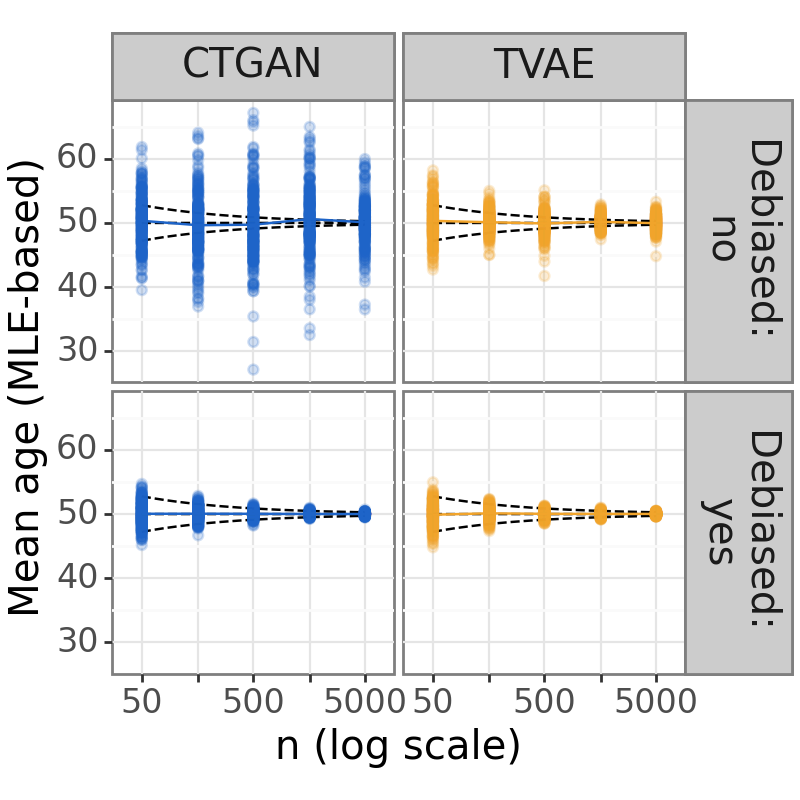

<Figure Size: (400 x 400)>

In [32]:
# Relabel
relabel_estimators = {'age_mean': 'Debiased:'}
relabel_generators = {'ctgan': 'CTGAN',
                      'tvae': 'TVAE'}
relabel_targeted = {'default': 'no',
                    'targeted': 'yes'}

# Plot
biasplot_agemean_main = plot_bias(meta_data.query('generator not in [\'original\', \'custom_ctgan\', \'custom_ctgan_targeted\', \'custom_tvae\', \'custom_tvae_targeted\']'),
                                  select_estimators=['age_mean'], 
                                  order_generators= ['ctgan', 'tvae'],
                                  targeted_facet='row',
                                  plot_outliers=True,
                                  unit_rescale=data_rescale,
                                  plot_estimates=True,
                                  ground_truth=data_gt) +\
    facet_grid('estimator + targeted ~ generator_class', scales='fixed', labeller=labeller(generator_class=lambda x: relabel_generators[x],
                                                                                           estimator=lambda x: relabel_estimators[x],
                                                                                           targeted=lambda x: relabel_targeted[x])) +\
    labs(y='Mean age (MLE-based)') +\
    scale_x_continuous(limits=[35,7000], breaks=[50,160,500,1600,5000], labels=[50,'',500,'',5000], trans='log') +\
    theme(plot_title=element_blank(), # title size
          axis_title=element_text(size=14.5), # axis title size
          strip_text=element_text(size=14.5), # facet_grid title size
          axis_text=element_text(size=12),
          panel_spacing=0.011, # add space between facets
          figure_size=(4,4)) # axis labels size 
biasplot_agemean_main

In [33]:
#biasplot_agemean_main.save(filename='plots/sim_bias_agemean_main.pdf')

**Plots (appendix)**

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.



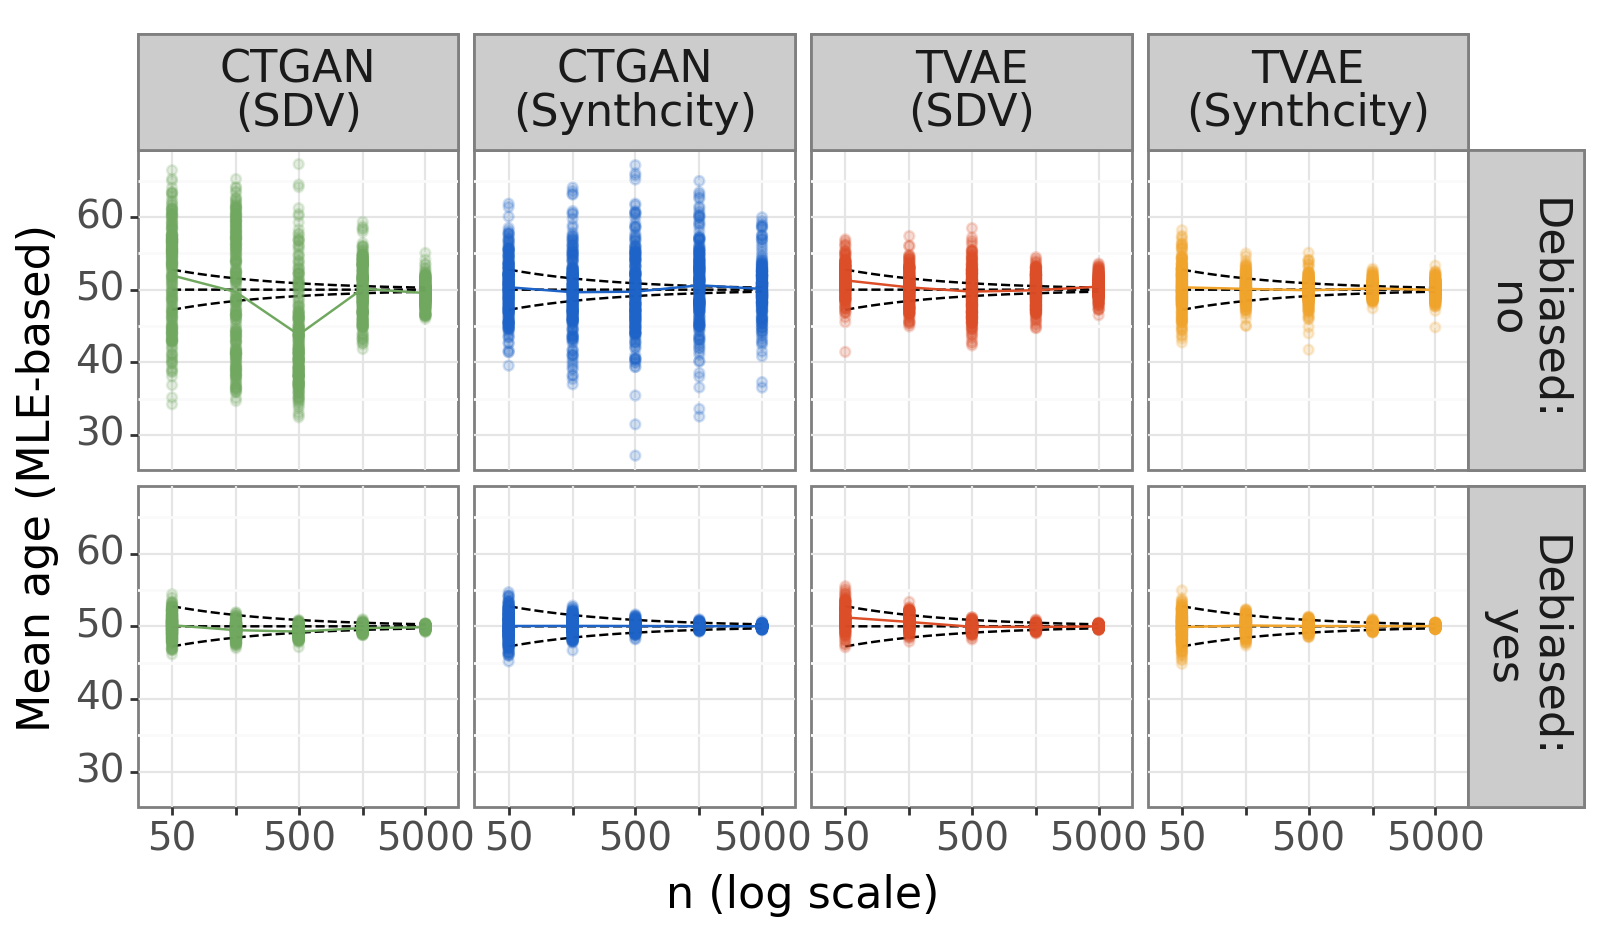

<Figure Size: (800 x 475)>

In [34]:
# Relabel
relabel_estimators = {'age_mean': 'Debiased:'}
relabel_generators = {'custom_ctgan': 'CTGAN\n(SDV)',
                      'ctgan': 'CTGAN\n(Synthcity)',
                      'custom_tvae': 'TVAE\n(SDV)',
                      'tvae': 'TVAE\n(Synthcity)'}
relabel_targeted = {'default': 'no',
                    'targeted': 'yes'}

# Plot
biasplot_agemean_appendix = plot_bias(meta_data.query('generator!=\'original\''), 
                                      select_estimators=['age_mean'], 
                                      order_generators= ['custom_ctgan', 'ctgan', 'custom_tvae', 'tvae'],
                                      targeted_facet='row',
                                      plot_outliers=True,
                                      unit_rescale=data_rescale,
                                      plot_estimates=True,
                                      ground_truth=data_gt) +\
    facet_grid('estimator + targeted ~ generator_class', scales='fixed', labeller=labeller(generator_class=lambda x: relabel_generators[x],
                                                                                           estimator=lambda x: relabel_estimators[x],
                                                                                           targeted=lambda x: relabel_targeted[x])) +\
    labs(y='Mean age (MLE-based)') +\
    scale_x_continuous(limits=[35,7000], breaks=[50,160,500,1600,5000], labels=[50,'',500,'',5000], trans='log') +\
    theme(plot_title=element_blank(), # title size
          axis_title=element_text(size=16), # axis title size
          strip_text=element_text(size=16), # facet_grid title size
          axis_text=element_text(size=14)) # axis labels size 
biasplot_agemean_appendix

In [35]:
#biasplot_agemean_appendix.save(filename='plots/sim_bias_agemean_appendix.pdf')

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_summary : Removed 10 rows containing non-finite values.
/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 10 rows containing missing values.


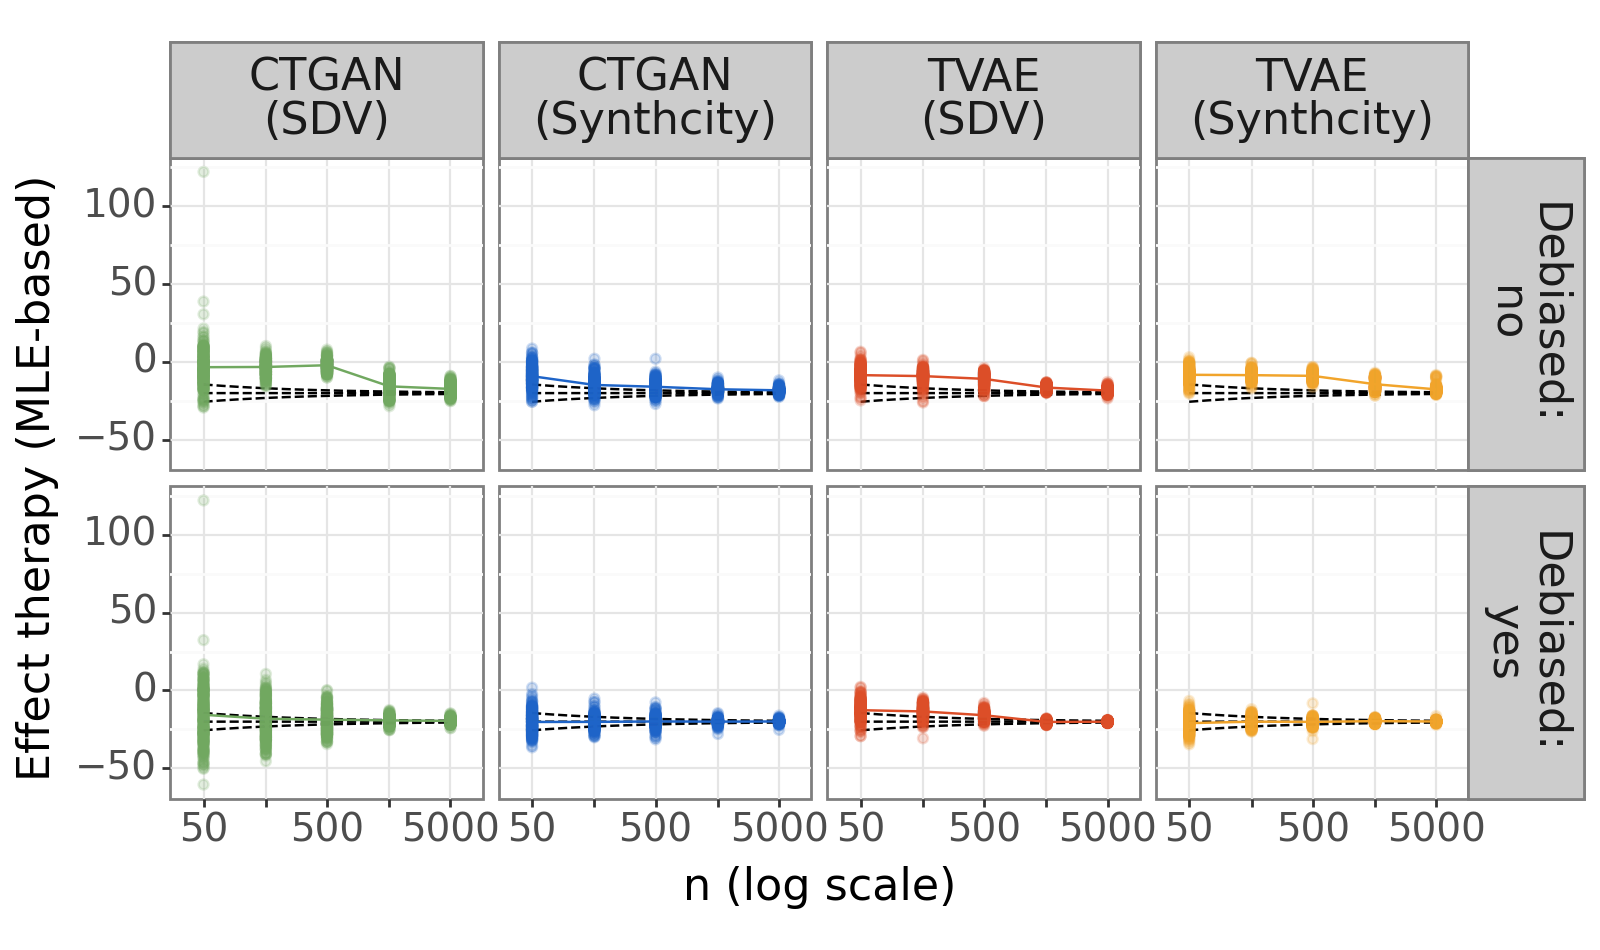

<Figure Size: (800 x 475)>

In [36]:
# Relabel
relabel_estimators = {'bp_therapy_ols': 'Debiased:'}
relabel_generators = {'custom_ctgan': 'CTGAN\n(SDV)',
                      'ctgan': 'CTGAN\n(Synthcity)',
                      'custom_tvae': 'TVAE\n(SDV)',
                      'tvae': 'TVAE\n(Synthcity)'}
relabel_targeted = {'default': 'no',
                    'targeted': 'yes'}

# Plot
biasplot_therapyols_appendix = plot_bias(meta_data.query('generator!=\'original\''), 
                                select_estimators=['bp_therapy_ols'], 
                                order_generators= ['custom_ctgan', 'ctgan', 'custom_tvae', 'tvae'],
                                targeted_facet='row',
                                plot_outliers=True,
                                unit_rescale=data_rescale,
                                plot_estimates=True,
                                ground_truth=data_gt) +\
    facet_grid('estimator + targeted ~ generator_class', scales='fixed', labeller=labeller(generator_class=lambda x: relabel_generators[x],
                                                                                           estimator=lambda x: relabel_estimators[x],
                                                                                           targeted=lambda x: relabel_targeted[x])) +\
    labs(y='Effect therapy (MLE-based)') +\
    scale_x_continuous(limits=[35,7000], breaks=[50,160,500,1600,5000], labels=[50,'',500,'',5000], trans='log') +\
    theme(plot_title=element_blank(), # title size
          axis_title=element_text(size=16), # axis title size
          strip_text=element_text(size=16), # facet_grid title size
          axis_text=element_text(size=14)) # axis labels size 
biasplot_therapyols_appendix

In [37]:
#biasplot_therapyols_appendix.save(filename='plots/sim_bias_therapyols_appendix.pdf')

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_summary : Removed 293 rows containing non-finite values.
/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 293 rows containing missing values.


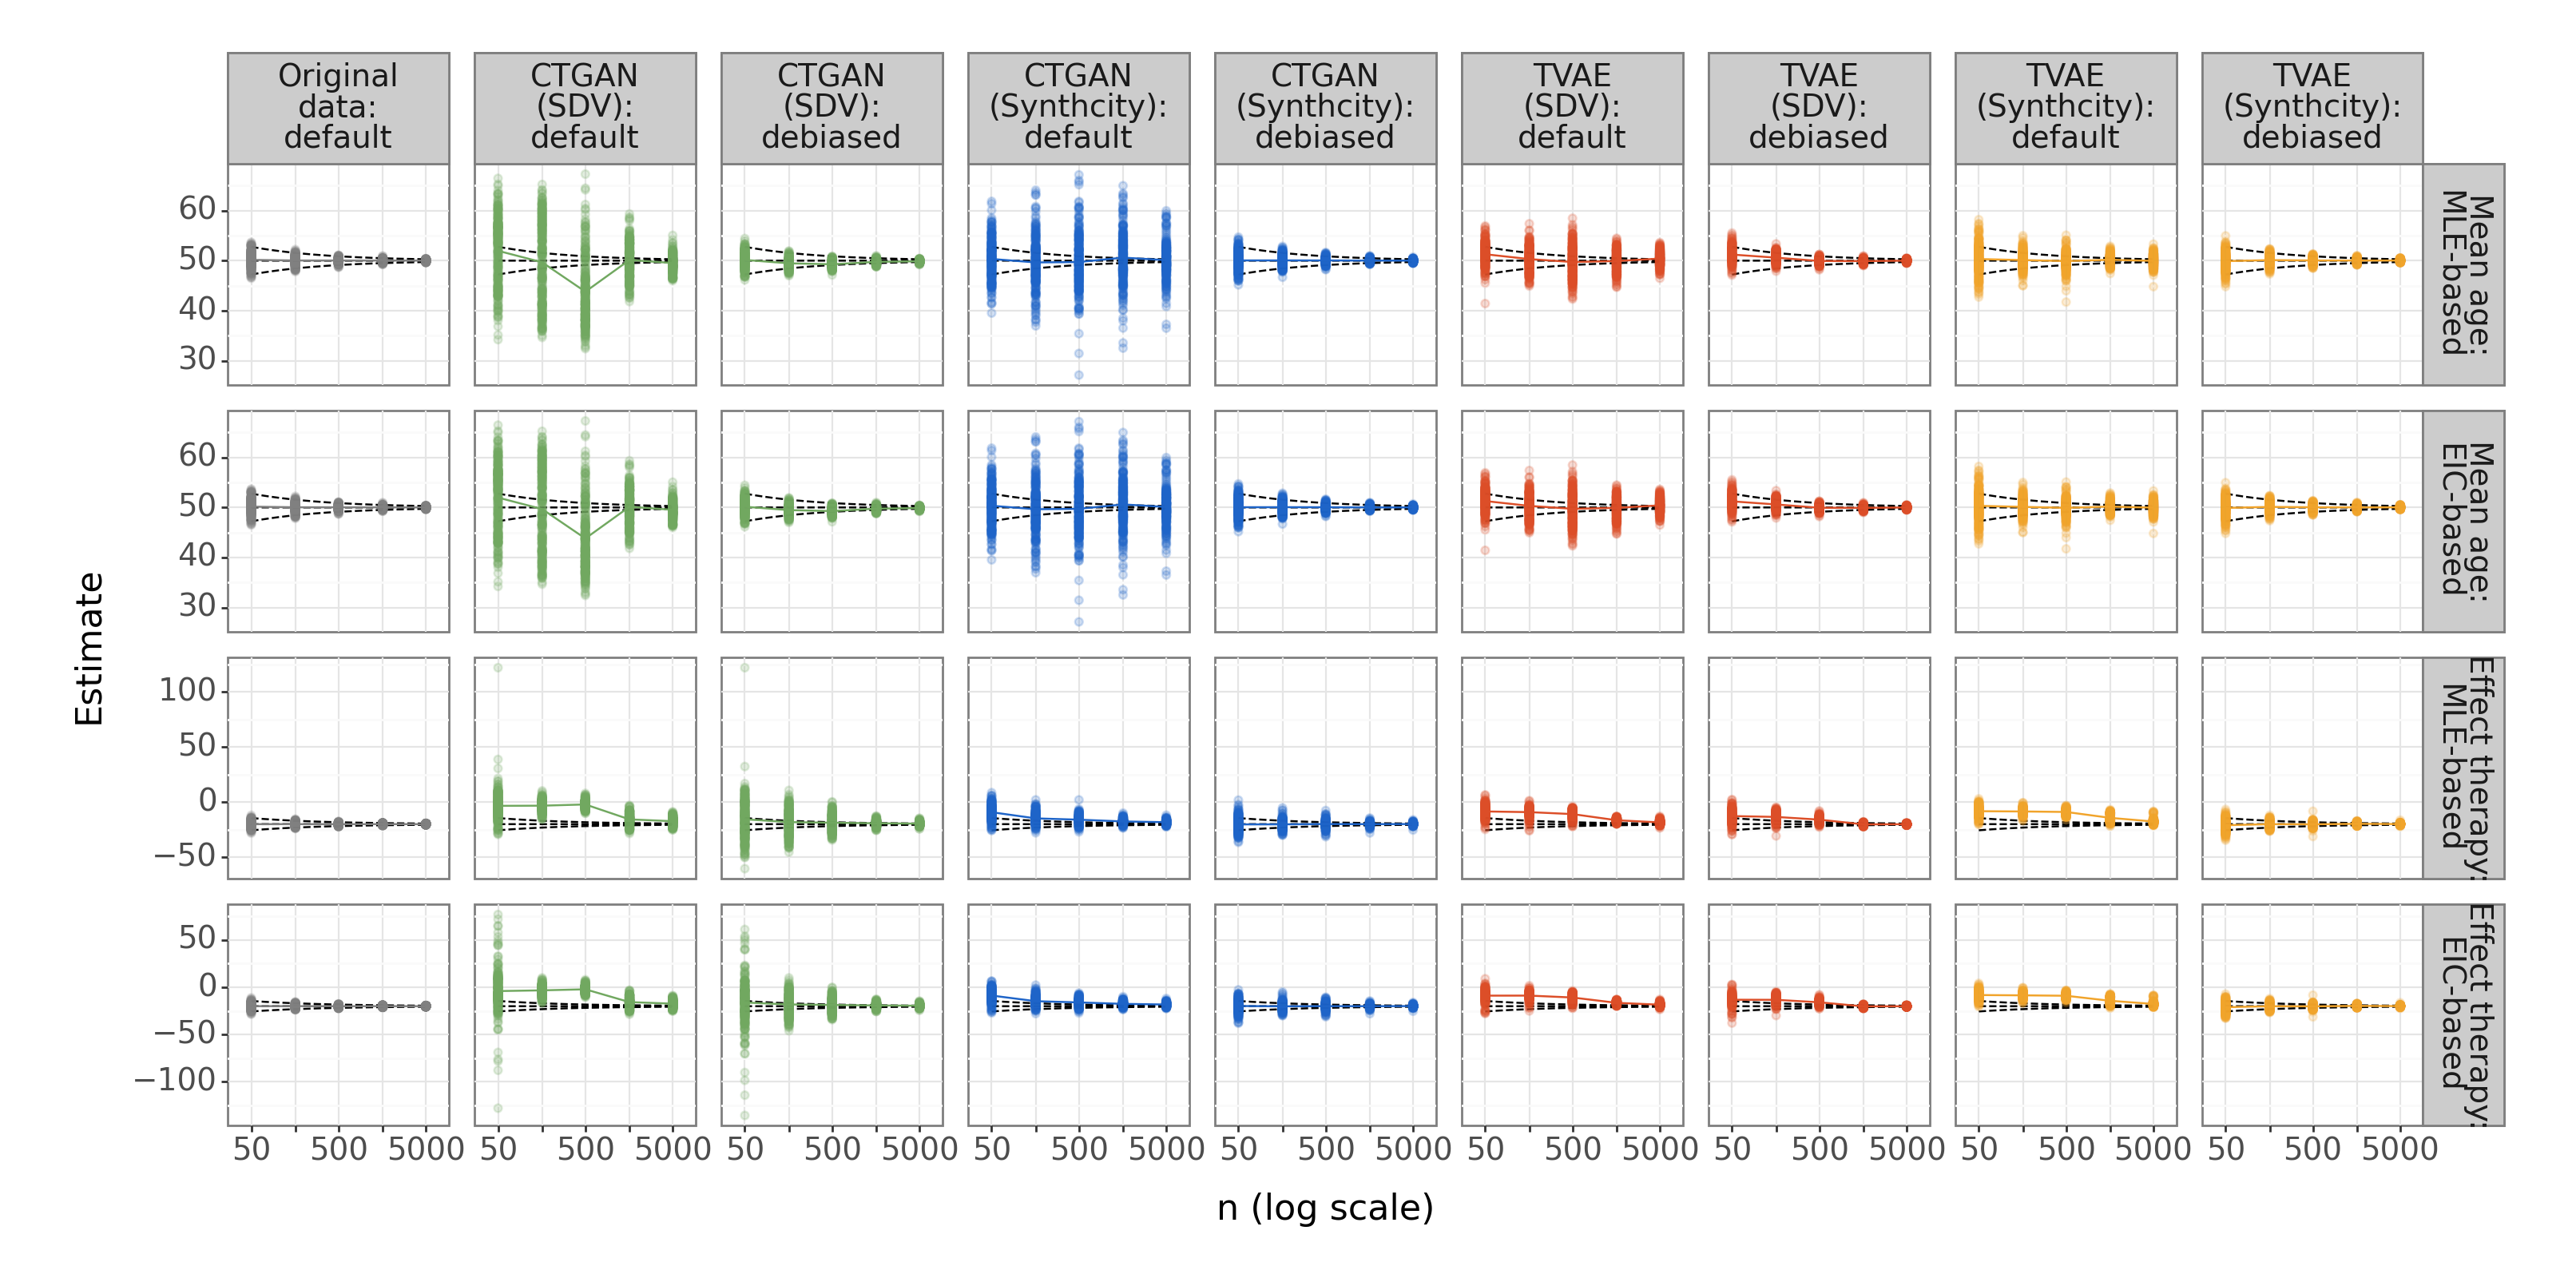

<Figure Size: (1612 x 800)>

In [38]:
# Relabel
relabel_estimators = {'age_mean': 'Mean age:\nMLE-based',
                      'age_meanic': 'Mean age:\nEIC-based', 
                      'bp_therapy_ols': 'Effect therapy:\nMLE-based',
                      'bp_therapy_olsic': 'Effect therapy:\nEIC-based'}
relabel_generators = {'original': 'Original\ndata:', 
                      'custom_ctgan': 'CTGAN\n(SDV):',
                      'ctgan': 'CTGAN\n(Synthcity):',
                      'custom_tvae': 'TVAE\n(SDV):',
                      'tvae': 'TVAE\n(Synthcity):'}
relabel_targeted = {'default': 'default',
                    'targeted': 'debiased'}

# Plot
biasplot_ic = plot_bias(meta_data, 
                         select_estimators=['age_mean', 'age_meanic', 'bp_therapy_ols', 'bp_therapy_olsic'], 
                         order_generators= ['original', 'custom_ctgan', 'ctgan', 'custom_tvae', 'tvae'],
                         targeted_facet='column',
                         plot_outliers=True,
                         unit_rescale=data_rescale,
                         plot_estimates=True,
                         ground_truth=data_gt) +\
    facet_grid('estimator ~ generator_class + targeted', scales='free', labeller=labeller(generator_class=lambda x: relabel_generators[x],
                                                                                          estimator=lambda x: relabel_estimators[x],
                                                                                          targeted=lambda x: relabel_targeted[x])) +\
    scale_x_continuous(limits=[35,7000], breaks=[50,160,500,1600,5000], labels=[50,'',500,'',5000], trans='log') +\
    theme(plot_title=element_blank(), # title size
          axis_title=element_text(size=16), # axis title size
          strip_text=element_text(size=14), # facet_grid title size
          axis_text=element_text(size=14)) # axis labels size 
biasplot_ic

In [30]:
#biasplot_ic.save(filename='plots/sim_bias_ic.pdf')

## Relative errors

**Plot (main text)**

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.



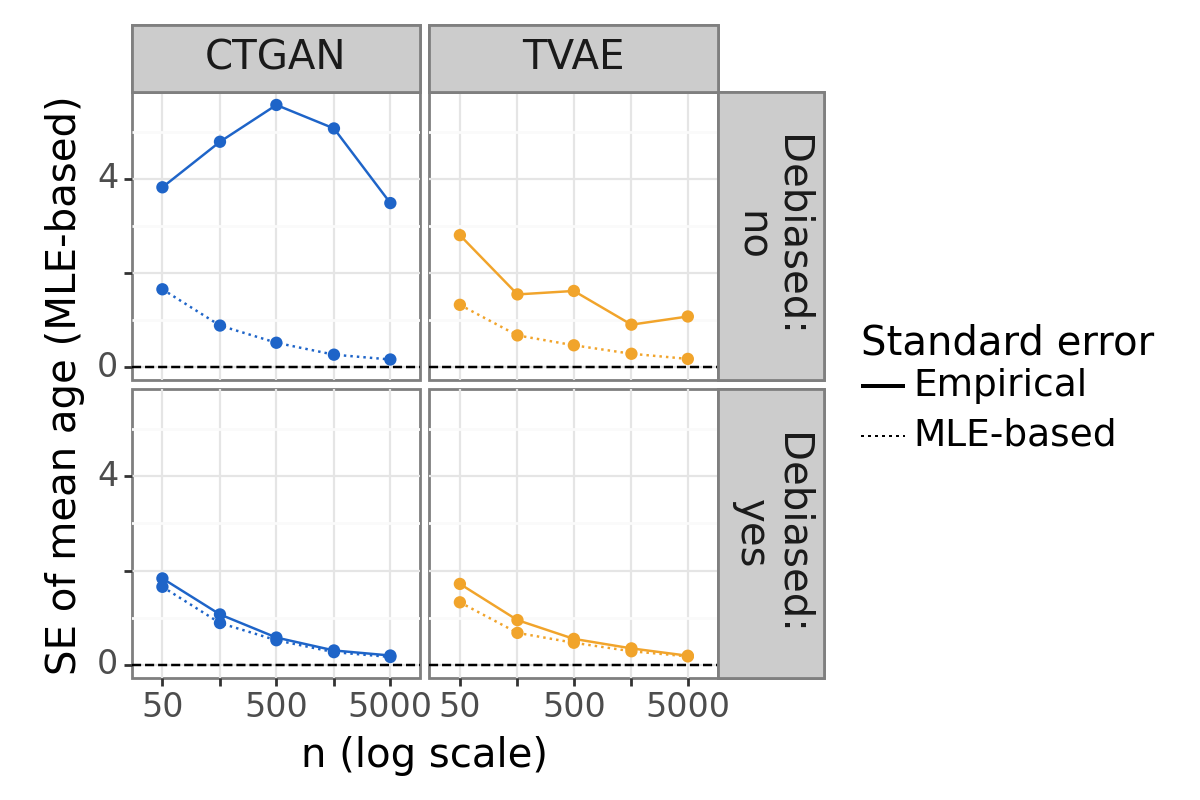

<Figure Size: (600 x 400)>

In [39]:
# Relabel
relabel_estimators = {'age_mean': 'Debiased:'}
relabel_generators = {'ctgan': 'CTGAN',
                      'tvae': 'TVAE'}
relabel_targeted = {'default': 'no',
                    'targeted': 'yes'}

# Plot
seplot_agemean_main = plot_compare_se(meta_data.query('generator not in [\'original\',  \'custom_ctgan\', \'custom_ctgan_targeted\', \'custom_tvae\', \'custom_tvae_targeted\']'),
                                      select_estimators=['age_mean'], 
                                      order_generators=['ctgan', 'tvae'],  
                                      correction_factor=np.sqrt(2),
                                      influence_curve=False,
                                      targeted_facet='row',
                                      figure_size=(4.5,5)) +\
    facet_grid('estimator + targeted ~ generator_class', scales='fixed', labeller=labeller(generator_class=lambda x: relabel_generators[x], 
                                                                                           estimator=lambda x: relabel_estimators[x],
                                                                                           targeted=lambda x: relabel_targeted[x])) +\
    labs(y='SE of mean age (MLE-based)') +\
    scale_y_continuous(breaks=[0,2,4,6,8], labels=[0,'',4,'',8]) +\
    scale_x_continuous(limits=[35,7000], breaks=[50,160,500,1600,5000], labels=[50,'',500,'',5000], trans='log') +\
    theme(plot_title=element_blank(), # title size
          axis_title=element_text(size=14.5), # axis title size
          strip_text=element_text(size=14.5), # facet_grid title size
          axis_text=element_text(size=12), # axis labels size 
          panel_spacing=0.0075, # add space between facets
          legend_position='right',
          legend_title=element_text(size=14.5), # legend title size
          legend_title_align='left',
          legend_text=element_text(size=13.5), # legend labels size 
          legend_key=element_blank(),
          figure_size=(6,4))
seplot_agemean_main

In [32]:
#seplot_agemean_main.save(filename='plots/sim_se_agemean_main.pdf')

**Plots (appendix)**

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.



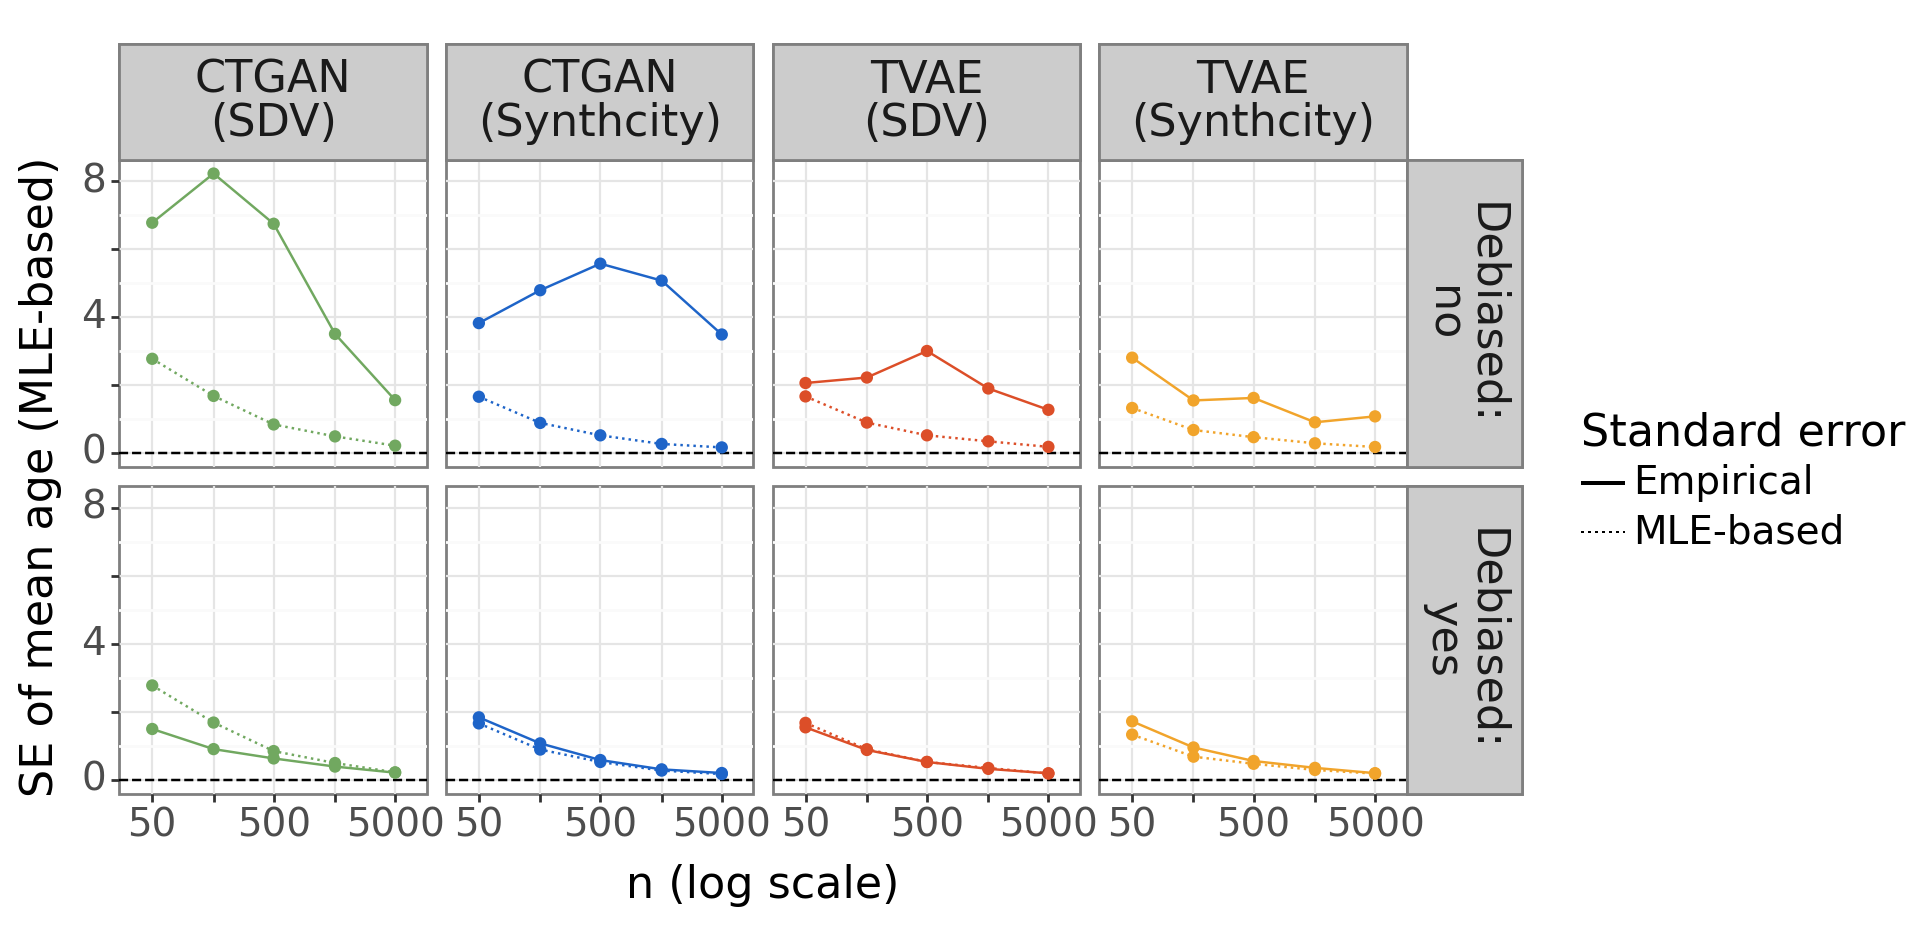

<Figure Size: (962 x 475)>

In [40]:
# Relabel
relabel_estimators = {'age_mean': 'Debiased:'}
relabel_generators = {'custom_ctgan': 'CTGAN\n(SDV)',
                      'ctgan': 'CTGAN\n(Synthcity)',
                      'custom_tvae': 'TVAE\n(SDV)',
                      'tvae': 'TVAE\n(Synthcity)'}
relabel_targeted = {'default': 'no',
                    'targeted': 'yes'}

# Plot
seplot_agemean_appendix = plot_compare_se(meta_data.query('generator !=\'original\''),
                                 select_estimators=['age_mean'], 
                                 order_generators=['custom_ctgan','ctgan', 'custom_tvae', 'tvae'],  
                                 correction_factor=np.sqrt(2),
                                 influence_curve=False,
                                 targeted_facet='row') +\
    facet_grid('estimator + targeted ~ generator_class', scales='fixed', labeller=labeller(generator_class=lambda x: relabel_generators[x], 
                                                                                           estimator=lambda x: relabel_estimators[x],
                                                                                           targeted=lambda x: relabel_targeted[x])) +\
    labs(y='SE of mean age (MLE-based)') +\
    scale_y_continuous(breaks=[0,2,4,6,8], labels=[0,'',4,'',8]) +\
    scale_x_continuous(limits=[35,7000], breaks=[50,160,500,1600,5000], labels=[50,'',500,'',5000], trans='log') +\
    theme(plot_title=element_blank(), # title size
          axis_title=element_text(size=16), # axis title size
          strip_text=element_text(size=16), # facet_grid title size
          axis_text=element_text(size=14), # axis labels size 
          legend_title=element_text(size=16), # legend title size
          legend_text=element_text(size=14), # legend labels size 
          legend_key=element_blank())
seplot_agemean_appendix

In [41]:
#seplot_agemean_appendix.save(filename='plots/sim_se_agemean_appendix.pdf')

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.



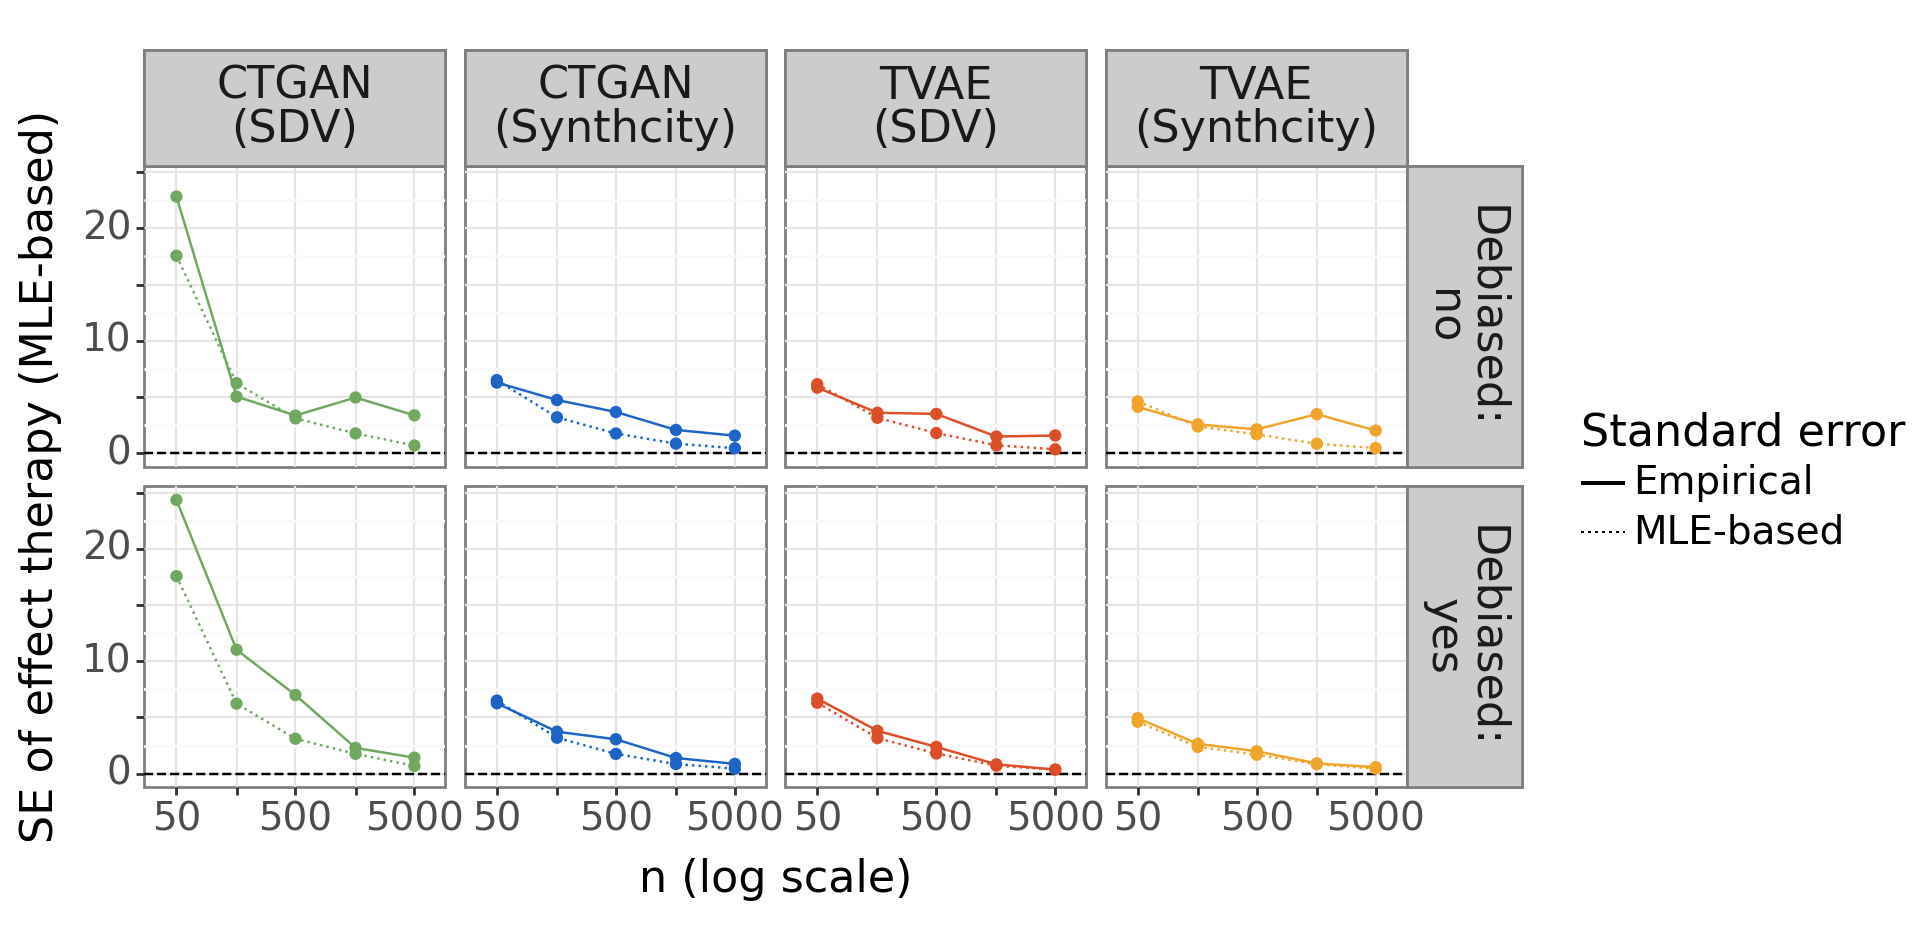

<Figure Size: (962 x 475)>

In [42]:
# Relabel
relabel_estimators = {'bp_therapy_ols': 'Debiased:'}
relabel_generators = {'custom_ctgan': 'CTGAN\n(SDV)',
                      'ctgan': 'CTGAN\n(Synthcity)',
                      'custom_tvae': 'TVAE\n(SDV)',
                      'tvae': 'TVAE\n(Synthcity)'}
relabel_targeted = {'default': 'no',
                    'targeted': 'yes'}

# Plot
seplot_therapyols_appendix = plot_compare_se(meta_data.query('generator !=\'original\''),
                                 select_estimators=['bp_therapy_ols'], 
                                 order_generators=['custom_ctgan','ctgan', 'custom_tvae', 'tvae'],  
                                 correction_factor=np.sqrt(2),
                                 influence_curve=False,
                                 targeted_facet='row') +\
    facet_grid('estimator + targeted ~ generator_class', scales='fixed', labeller=labeller(generator_class=lambda x: relabel_generators[x], 
                                                                                           estimator=lambda x: relabel_estimators[x],
                                                                                           targeted=lambda x: relabel_targeted[x])) +\
    labs(y='SE of effect therapy (MLE-based)') +\
    scale_y_continuous(breaks=[0,5,10,15,20,25], labels=[0,'',10,'',20,'']) +\
    scale_x_continuous(limits=[35,7000], breaks=[50,160,500,1600,5000], labels=[50,'',500,'',5000], trans='log') +\
    theme(plot_title=element_blank(), # title size
          axis_title=element_text(size=16), # axis title size
          strip_text=element_text(size=16), # facet_grid title size
          axis_text=element_text(size=14), # axis labels size 
          legend_title=element_text(size=16), # legend title size
          legend_text=element_text(size=14), # legend labels size 
          legend_key=element_blank())
seplot_therapyols_appendix

In [43]:
#seplot_therapyols_appendix.save(filename='plots/sim_se_therapyols_appendix.pdf')

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.



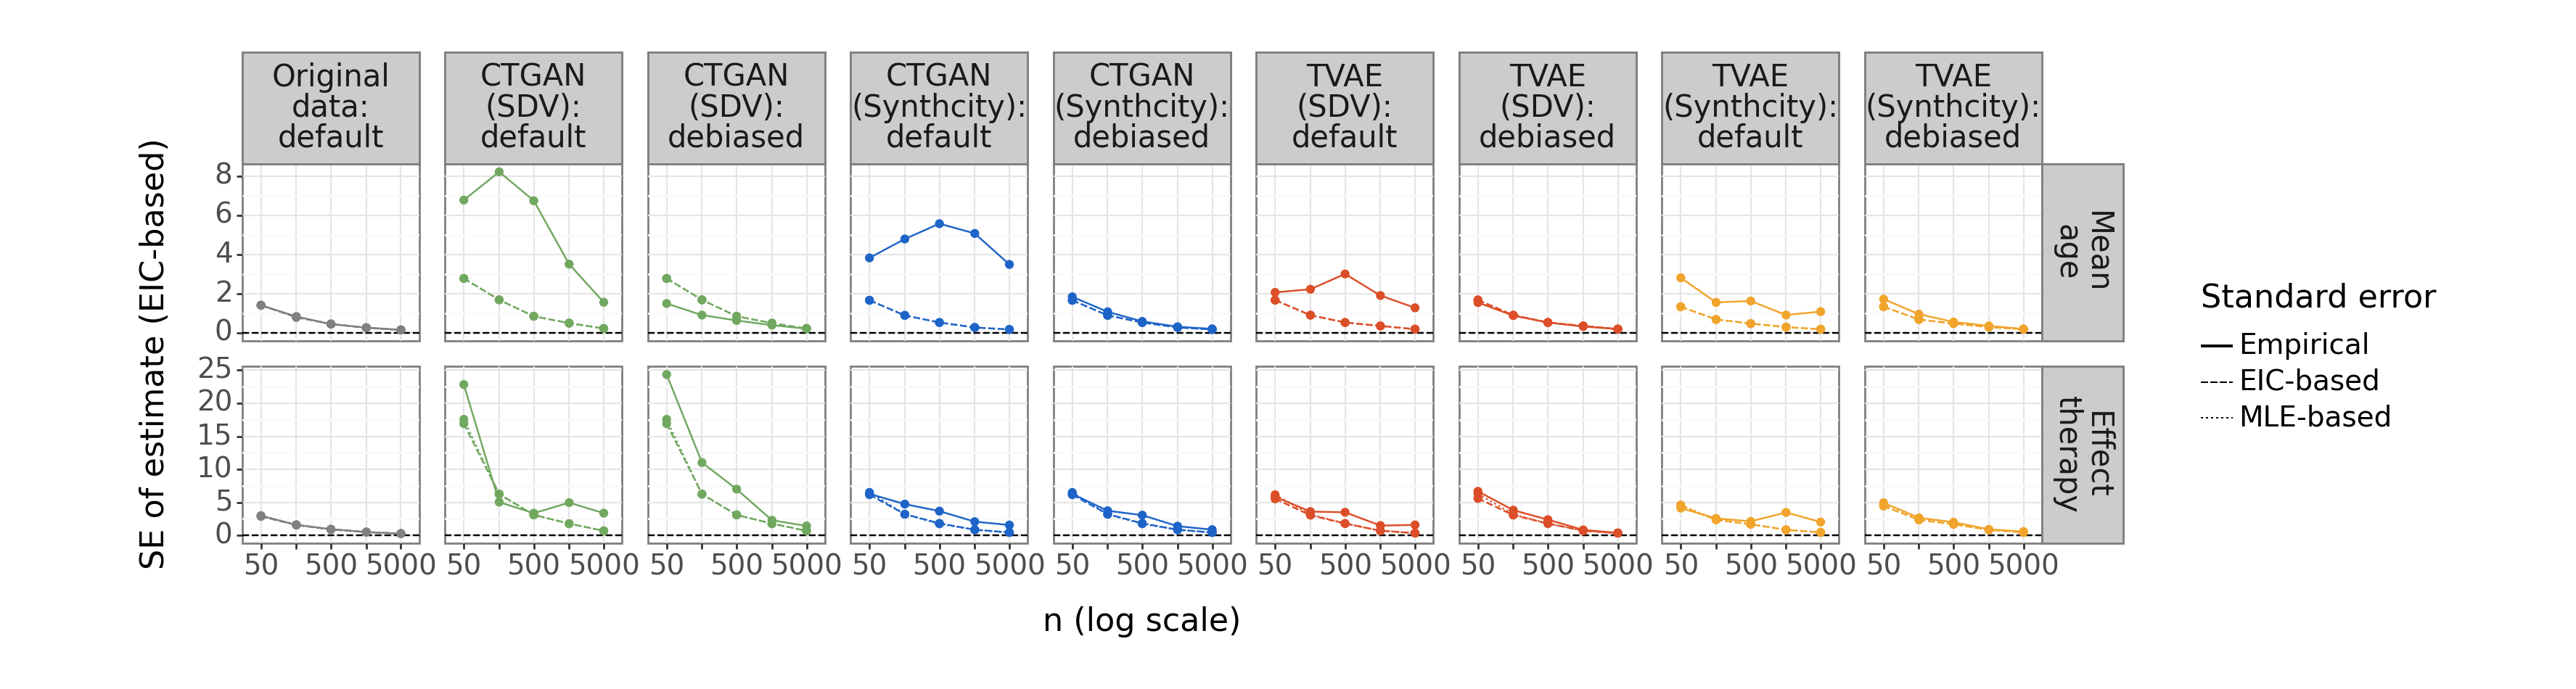

<Figure Size: (1775 x 475)>

In [45]:
# Relabel
relabel_estimators = {'age_mean': 'Mean\nage', 
                      'bp_therapy_ols': 'Effect\ntherapy'}
relabel_generators = {'original': 'Original\ndata:', 
                      'custom_ctgan': 'CTGAN\n(SDV):',
                      'ctgan': 'CTGAN\n(Synthcity):',
                      'custom_tvae': 'TVAE\n(SDV):',
                      'tvae': 'TVAE\n(Synthcity):'}
relabel_targeted = {'default': 'default',
                    'targeted': 'debiased'}

# Plot
seplot_ic = plot_compare_se(meta_data,
                             select_estimators=['age_mean', 'bp_therapy_ols'], 
                             order_generators=['original', 'custom_ctgan', 'ctgan', 'custom_tvae', 'tvae'],
                             correction_factor=np.sqrt(2),
                             influence_curve=True,
                             targeted_facet='column') +\
    facet_grid('estimator ~ generator_class + targeted', scales='free', labeller=labeller(generator_class=lambda x: relabel_generators[x], 
                                                                                          estimator=lambda x: relabel_estimators[x],
                                                                                          targeted=lambda x: relabel_targeted[x])) +\
    labs(y='SE of estimate (EIC-based)') +\
    scale_x_continuous(limits=[35,7000], breaks=[50,160,500,1600,5000], labels=[50,'',500,'',5000], trans='log') +\
    theme(plot_title=element_blank(), # title size
          axis_title=element_text(size=16), # axis title size
          strip_text=element_text(size=15), # facet_grid title size
          axis_text=element_text(size=14), # axis labels size 
          legend_title=element_text(size=16), # legend title size
          legend_text=element_text(size=14), # legend labels size 
          legend_key=element_blank())
seplot_ic

In [46]:
#seplot_ic.save(filename='plots/sim_se_ic.pdf')

**Plot (not presented in paper)**

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_summary : Removed 283 rows containing non-finite values.
/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 283 rows containing missing values.


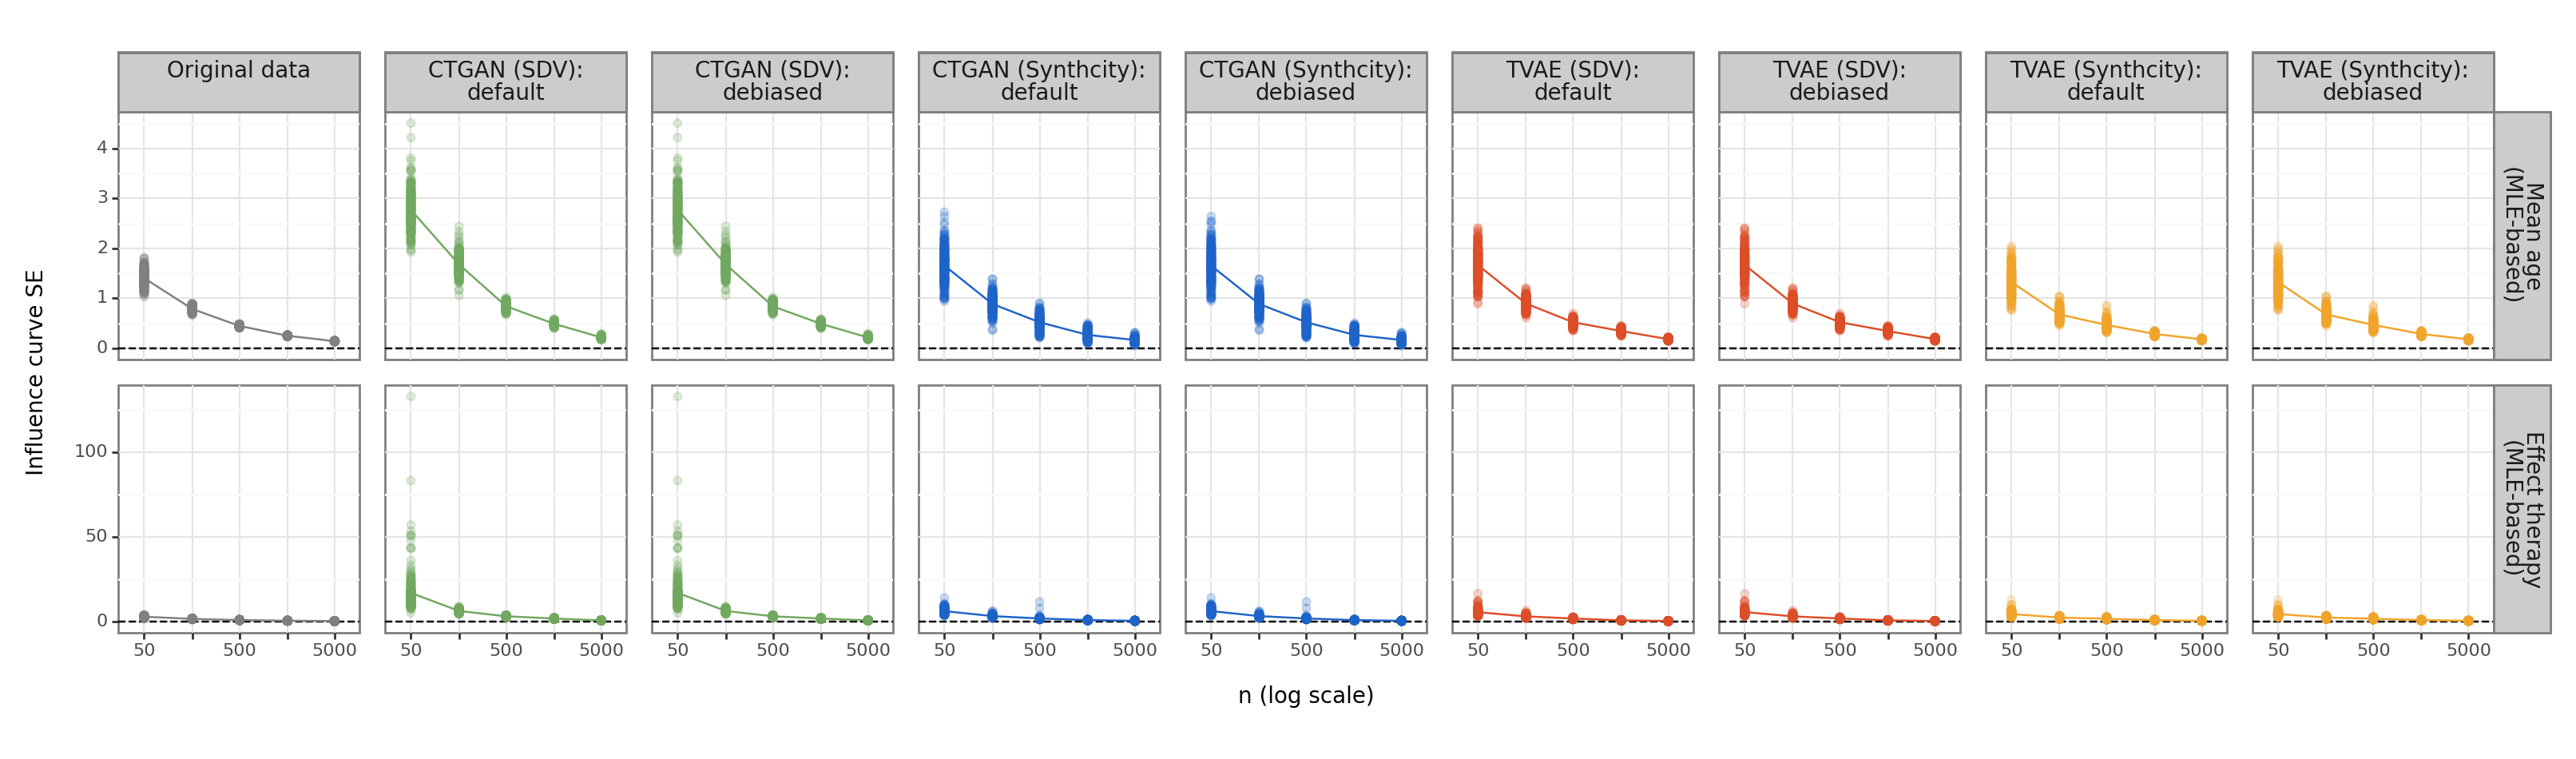

<Figure Size: (1612 x 475)>

In [47]:
# Relabel
relabel_estimators = {'age_mean': 'Mean age\n(MLE-based)', 
                      'bp_therapy_ols': 'Effect therapy\n(MLE-based)'}
relabel_generators = {'original': 'Original data\n', 
                      'custom_ctgan': 'CTGAN (SDV):\ndefault',
                      'custom_ctgan_targeted': 'CTGAN (SDV):\ndebiased',
                      'ctgan': 'CTGAN (Synthcity):\ndefault',
                      'ctgan_targeted': 'CTGAN (Synthcity):\ndebiased',
                      'custom_tvae': 'TVAE (SDV):\ndefault',
                      'custom_tvae_targeted': 'TVAE (SDV):\ndebiased',
                      'tvae': 'TVAE (Synthcity):\ndefault',
                      'tvae_targeted': 'TVAE (Synthcity):\ndebiased'}
# Plot
plot_ic_se(meta_data, 
           select_estimators=['age_mean', 'bp_therapy_ols'], 
           order_generators=['original', 'custom_ctgan', 'custom_ctgan_targeted', 'ctgan', 'ctgan_targeted',
                             'custom_tvae', 'custom_tvae_targeted', 'tvae', 'tvae_targeted'],
           correction_factor=np.sqrt(2)) +\
    facet_grid('estimator ~ generator', scales='free', labeller=labeller(generator=lambda x: relabel_generators[x], estimator=lambda x: relabel_estimators[x])) +\
    scale_x_continuous(limits=[35,7000], breaks=[50,160,500,1600,5000], labels=[50,'',500,'',5000], trans='log') +\
    theme(plot_title=element_blank(), # title size
          axis_title=element_text(size=10), # axis title size
          strip_text=element_text(size=10), # facet_grid title size
          strip_text_y=element_text(margin={'l': 3, 'r': 3, 'units': 'pt'}), # facet_grid margin
          axis_text=element_text(size=8)) # axis labels size 

**Table (not presented in paper)**

In [48]:
# Presets
select_generators = ['custom_ctgan', 'custom_ctgan_targeted', 'ctgan', 'ctgan_targeted',
                     'custom_tvae', 'custom_tvae_targeted', 'tvae', 'tvae_targeted']
select_n = [50, 5000]
select_metrics = ['relative_bias', 'SE_underestimation']
order_columns = ['n', 'estimator'] + select_metrics
select_rows = ['age_mean', 'age_meanic', 'bp_therapy_ols', 'bp_therapy_olsic']

# Display table
summary_data = summary_table(meta_data, ground_truth=data_gt, select_estimators=select_rows, correction_factor=np.sqrt(2)) 
se_underest = pd.DataFrame({})
for gen in select_generators:
    se_underest = pd.concat([se_underest,
                             summary_data.query(f'generator==\'{gen}\' & n in {select_n}')[order_columns].pivot(index='estimator', columns='n').loc[select_rows]],
                            axis=1)
(se_underest*100).style.format(precision=2) # in percentage

## Convergence rate

**Table MSE/SE/bias (main text and appendix)**

In [49]:
# Presets
order_columns = ['original', 'custom_ctgan', 'custom_ctgan_targeted', 'ctgan', 'ctgan_targeted',
                 'custom_tvae', 'custom_tvae_targeted', 'tvae', 'tvae_targeted']
order_columns = [('convergence rate', generator) for generator in order_columns]
select_rows = [column[:-len('_bias')] for column in meta_data.columns if 'bias' in column]


# Table MSE
conv_rate_MSE = table_convergence_rate(meta_data,
                                       intercept=True,
                                       metric='MSE',
                                       round_decimals=2,
                                       show_ci=True).pivot(index='estimator', columns='generator').loc[select_rows,order_columns]

# Table SE
conv_rate_se = table_convergence_rate(meta_data,
                                      intercept=True,
                                      metric='se',
                                      round_decimals=2,
                                      show_ci=True).pivot(index='estimator', columns='generator').loc[select_rows,order_columns]

# Table bias
conv_rate_bias = table_convergence_rate(meta_data,
                                        intercept=True,
                                        metric='bias',
                                        round_decimals=2,
                                        show_ci=True).pivot(index='estimator', columns='generator').loc[select_rows,order_columns]


# Display combined tables MSE/SE/bias
pd.set_option('display.max_colwidth', None) # display the maximum width of each single field.
conv_rate_MSE.combine(conv_rate_se, lambda s1, s2: s1 + ' / ' + s2).combine(conv_rate_bias, lambda s1, s2: s1 + ' / ' + s2)

convergence rate  \
generator                                                            original   
estimator                                                                       
age_mean            0.50 [0.47; 0.52] / 0.50 [0.47; 0.52] / 0.73 [0.25; 1.21]   
age_meanic          0.50 [0.47; 0.52] / 0.50 [0.47; 0.52] / 0.73 [0.25; 1.21]   
bp_therapy_ols    0.51 [0.47; 0.56] / 0.51 [0.48; 0.55] / -0.05 [-0.97; 0.88]   
bp_therapy_olsic   0.52 [0.49; 0.56] / 0.52 [0.49; 0.56] / 0.29 [-0.26; 0.84]   

                                                                               \
generator                                                        custom_ctgan   
estimator                                                                       
age_mean          0.33 [-0.04; 0.69] / 0.33 [0.04; 0.62] / 0.33 [-0.90; 1.56]   
age_meanic        0.33 [-0.04; 0.69] / 0.33 [0.04; 0.62] / 0.33 [-0.90; 1.56]   
bp_therapy_ols     0.36 [0.12; 0.60] / 0.23 [-0.09; 0.56] / 0.43 [0.06; 0.81]   
bp_therapy_olsic   0.41 [0.21; 0.61] / 0.33 [-0.11; 0.78] / 0.43 [0.04; 0.81]   

                                                                              \
generator                                              custom_ctgan_targeted   
estimator                                                                      
age_mean          0.39 [0.22; 0.56] / 0.42 [0.36; 0.48] / 0.10 [-0.57; 0.76]   
age_meanic        0.39 [0.22; 0.56] / 0.42 [0.36; 0.48] / 0.10 [-0.57; 0.76]   
bp_therapy_ols     0.57 [0.43; 0.71] / 0.58 [0.43; 0.73] / 0.46 [0.35; 0.56]   
bp_therapy_olsic   0.62 [0.50; 0.74] / 0.63 [0.50; 0.75] / 0.44 [0.36; 0.51]   

                                                                                \
generator                                                                ctgan   
estimator                                                                        
age_mean          0.01 [-0.16; 0.18] / 0.01 [-0.16; 0.18] / 0.16 [-0.36; 0.68]   
age_meanic        0.01 [-0.16; 0.18] / 0.01 [-0.16; 0.18] / 0.16 [-0.35; 0.68]   
bp_therapy_ols       0.36 [0.29; 0.42] / 0.31 [0.22; 0.40] / 0.38 [0.28; 0.48]   
bp_therapy_olsic     0.36 [0.30; 0.43] / 0.31 [0.24; 0.38] / 0.39 [0.29; 0.49]   

                                                                              \
generator                                                     ctgan_targeted   
estimator                                                                      
age_mean           0.50 [0.45; 0.54] / 0.50 [0.46; 0.54] / 0.38 [0.06; 0.69]   
age_meanic         0.50 [0.45; 0.54] / 0.50 [0.46; 0.54] / 0.38 [0.06; 0.69]   
bp_therapy_ols    0.43 [0.31; 0.54] / 0.43 [0.31; 0.55] / 0.27 [-0.42; 0.95]   
bp_therapy_olsic  0.43 [0.32; 0.54] / 0.43 [0.32; 0.54] / 0.24 [-0.45; 0.93]   

                                                                                \
generator                                                          custom_tvae   
estimator                                                                        
age_mean          0.12 [-0.07; 0.31] / 0.10 [-0.13; 0.32] / 0.32 [-0.41; 1.06]   
age_meanic        0.12 [-0.07; 0.31] / 0.10 [-0.13; 0.32] / 0.32 [-0.41; 1.06]   
bp_therapy_ols       0.39 [0.16; 0.62] / 0.28 [0.10; 0.46] / 0.44 [0.16; 0.72]   
bp_therapy_olsic     0.40 [0.16; 0.63] / 0.30 [0.13; 0.48] / 0.44 [0.14; 0.73]   

                                                                             \
generator                                              custom_tvae_targeted   
estimator                                                                     
age_mean          0.51 [0.46; 0.56] / 0.45 [0.44; 0.47] / 1.10 [0.53; 1.66]   
age_meanic        0.51 [0.46; 0.56] / 0.45 [0.44; 0.47] / 1.10 [0.53; 1.66]   
bp_therapy_ols    0.75 [0.38; 1.13] / 0.61 [0.43; 0.79] / 1.30 [0.46; 2.15]   
bp_therapy_olsic  0.76 [0.38; 1.13] / 0.64 [0.48; 0.79] / 1.30 [0.43; 2.17]   

                                                                              \
generator          

**Plots (appendix)**

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'color' is already present.
Adding another scale for 'color',
which will replace the existing scale.

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'linetype' is already present.
Adding another scale for 'linetype',
which will replace the existing scale.



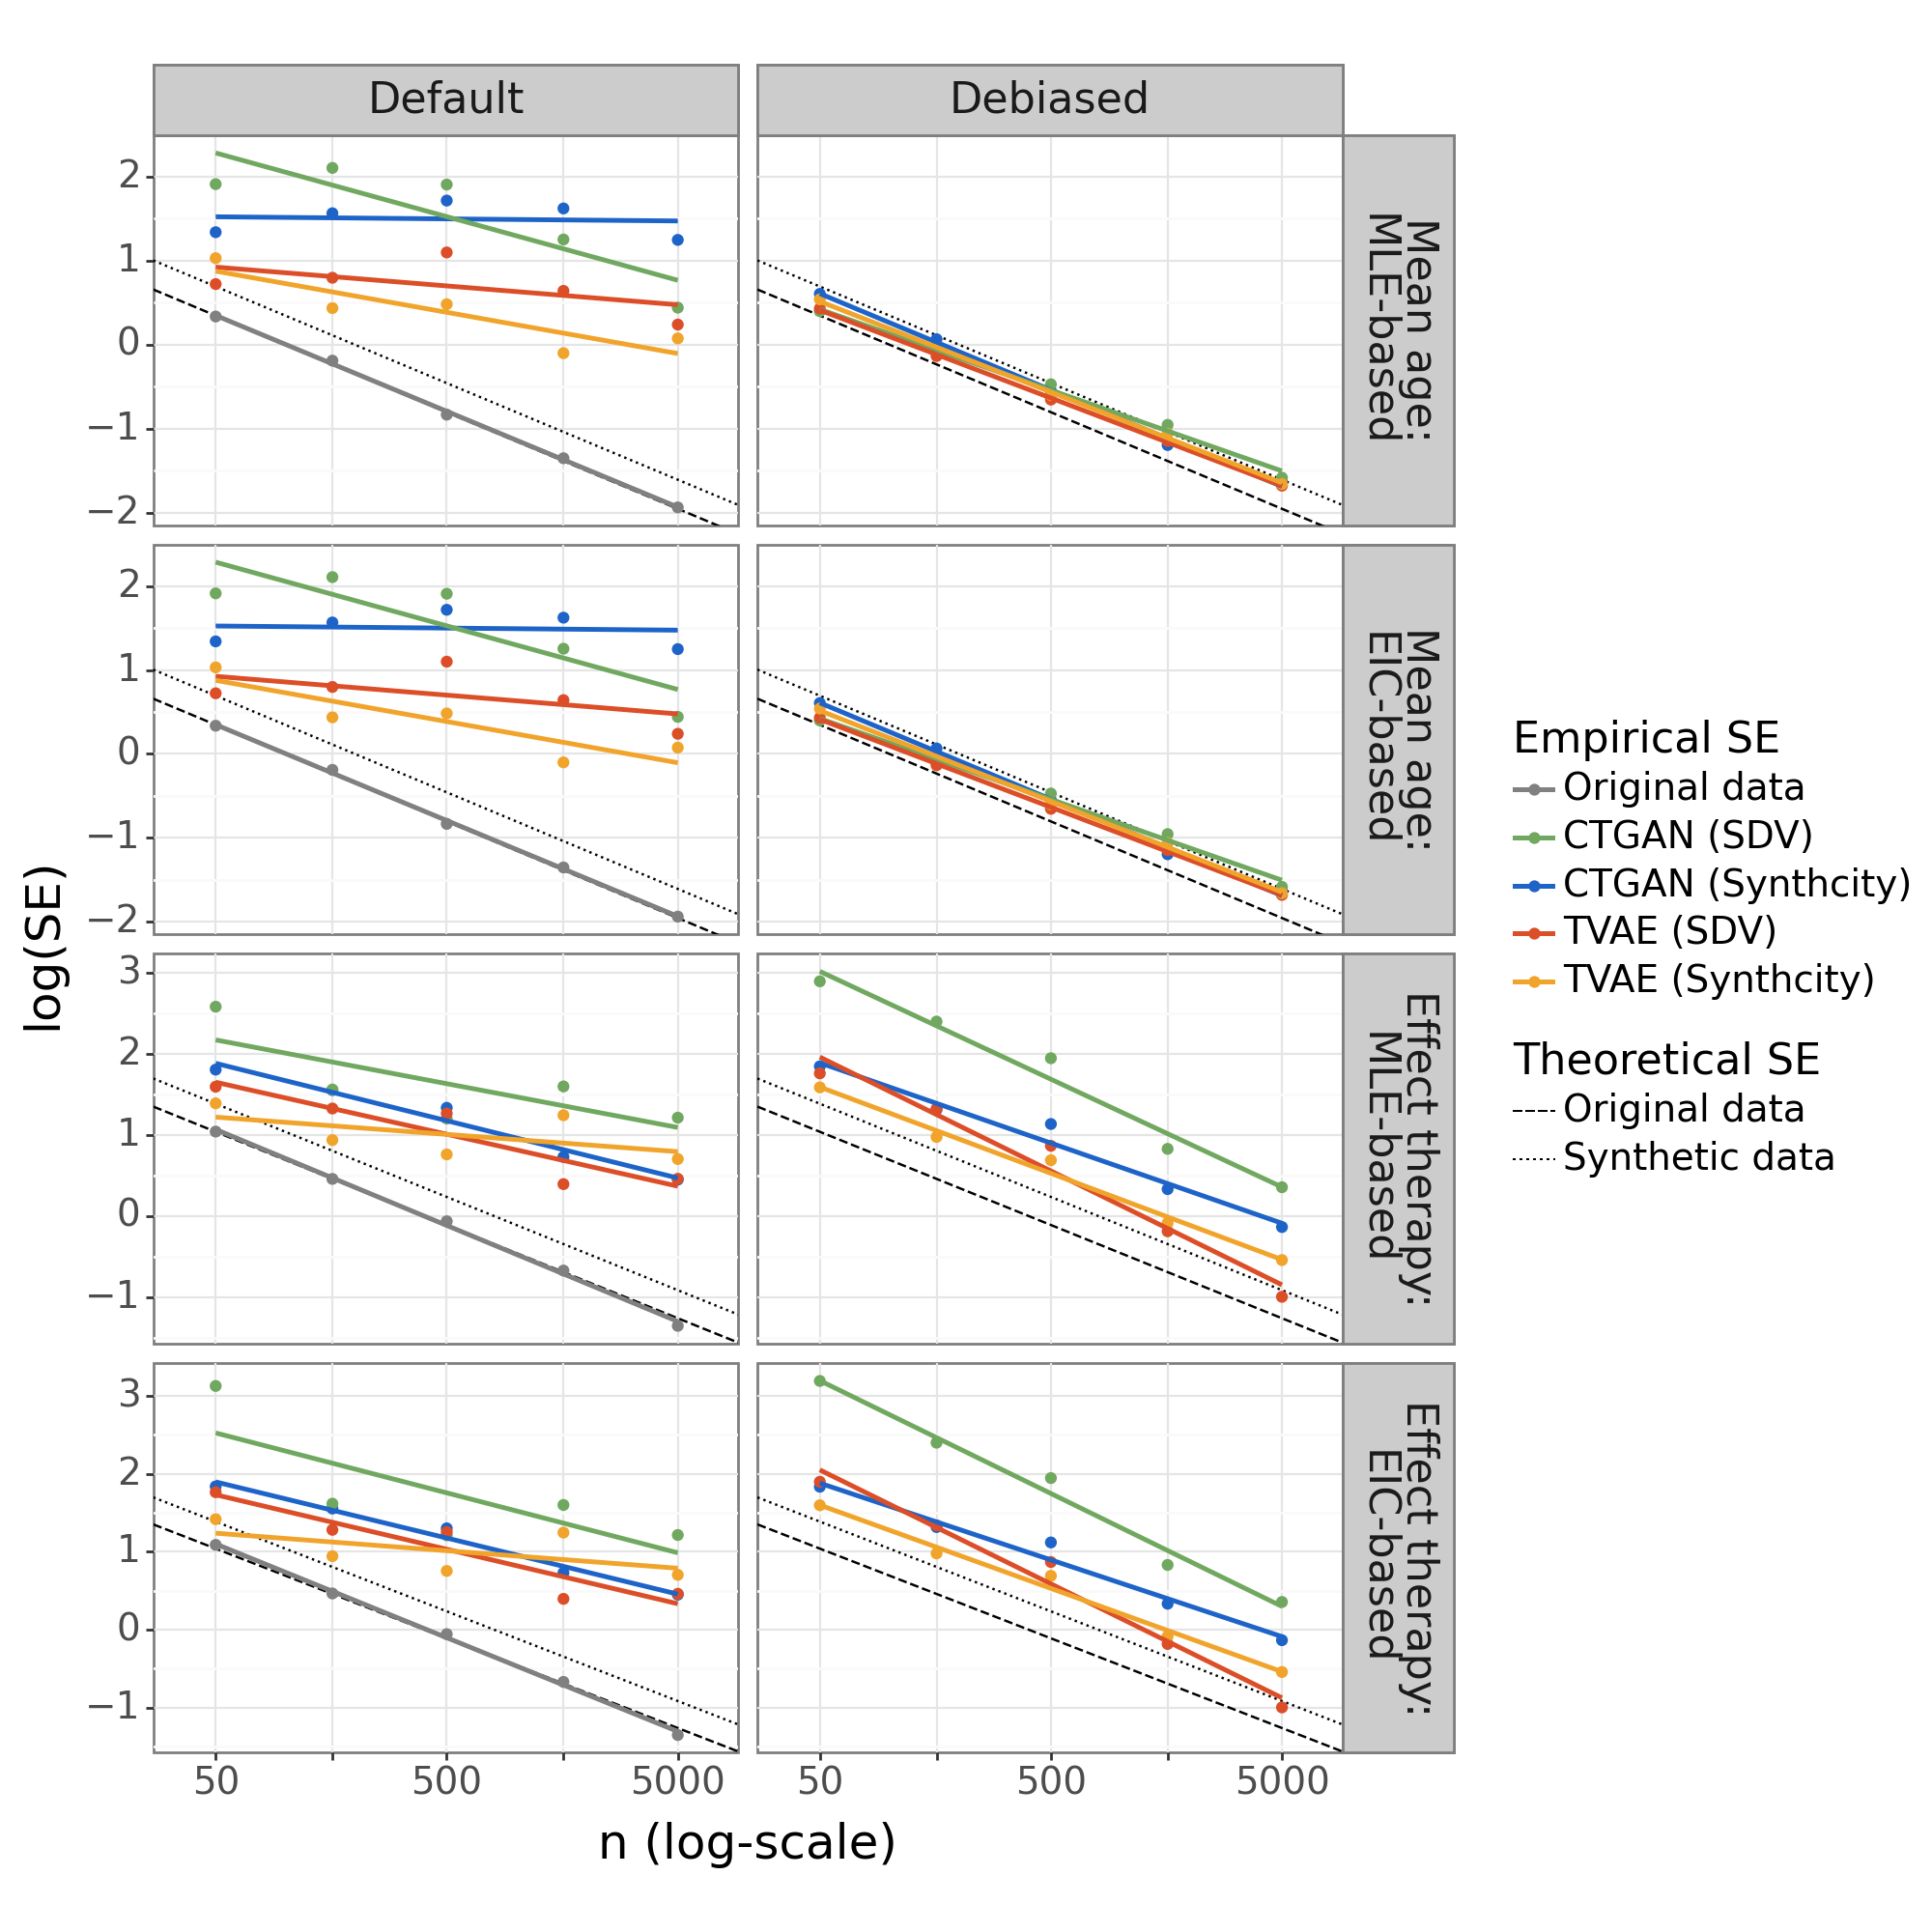

<Figure Size: (1000 x 1000)>

In [50]:
# Relabel
relabel_estimators = {'age_mean': 'Mean age:\nMLE-based',
                      'age_meanic': 'Mean age:\nEIC-based', 
                      'bp_therapy_ols': 'Effect therapy:\nMLE-based',
                      'bp_therapy_olsic': 'Effect therapy:\nEIC-based'}
relabel_targeted = {'default': 'Default',
                    'targeted': 'Debiased'}

# Plot
convergenceplot_all = plot_convergence_rate(
        meta_data,
        select_estimators=['age_mean', 'age_meanic',
                           'bp_therapy_ols', 'bp_therapy_olsic'],
        order_generators=['original', 'custom_ctgan', 'ctgan', 'custom_tvae', 'tvae'],
        unit_rescale=data_rescale, 
        metric='se', 
        check_root_n=False,
    figure_size=(10,10)) +\
    facet_grid('estimator ~ targeted', scales='free', labeller=labeller(estimator=lambda x: relabel_estimators[x],
                                                                        targeted=lambda x: relabel_targeted[x])) +\
    labs(color='Empirical SE', linetype='Theoretical SE', x='n (log-scale)', y='log(SE)') +\
    scale_x_continuous(limits=[35,7000], breaks=[50,160,500,1600,5000], labels=[50,'',500,'',5000], trans='log') +\
    scale_colour_manual(values={'original': '#808080', 'custom_ctgan': '#71A860', 'ctgan': '#1E64C8', 'custom_tvae': '#DC4E28', 'tvae': '#F1A42B'}, # relabel legend                    
                        labels=['Original data', 'CTGAN (SDV)', 'CTGAN (Synthcity)', 'TVAE (SDV)', 'TVAE (Synthcity)']) +\
    scale_linetype_manual(values={'naive': 'dashed', 'corrected': 'dotted'}, # relabel legend
                          labels=['Original data', 'Synthetic data']) +\
    theme(plot_title=element_blank(), # title size
          axis_title=element_text(size=18), # axis title size
          strip_text=element_text(size=16), # facet_grid title size
          axis_text=element_text(size=14), # axis labels size
          legend_title=element_text(size=16), # legend title size
          legend_text=element_text(size=14), # legend labels size 
          legend_key=element_blank())
convergenceplot_all

In [51]:
#convergenceplot_all.save('plots/sim_convergence_all.pdf')

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'color' is already present.
Adding another scale for 'color',
which will replace the existing scale.

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'linetype' is already present.
Adding another scale for 'linetype',
which will replace the existing scale.



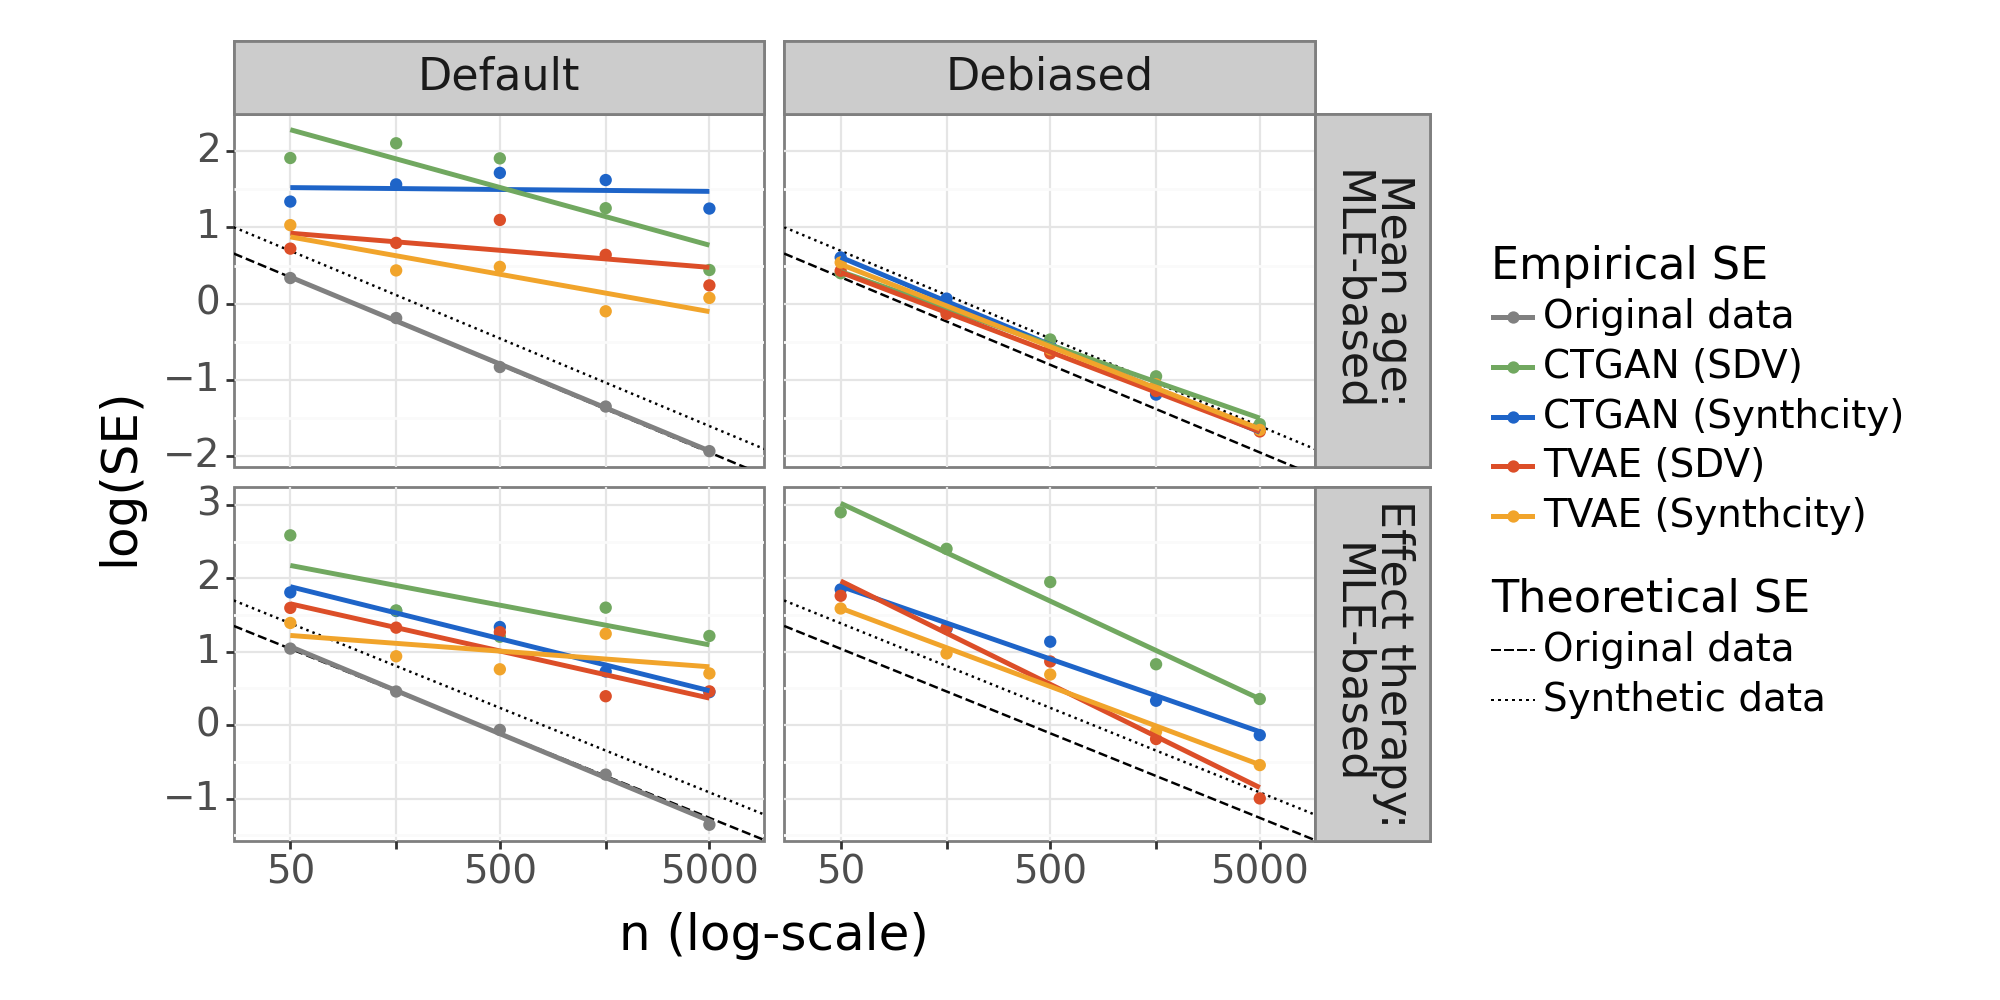

<Figure Size: (1000 x 500)>

In [52]:
# Relabel
relabel_estimators = {'age_mean': 'Mean age:\nMLE-based',
                      'bp_therapy_ols': 'Effect therapy:\nMLE-based'}
relabel_targeted = {'default': 'Default',
                    'targeted': 'Debiased'}

# Plot
convergenceplot_modelbased = plot_convergence_rate(
        meta_data,
        select_estimators=['age_mean', 'bp_therapy_ols'],
        order_generators=['original', 'custom_ctgan', 'ctgan', 'custom_tvae', 'tvae'],
        unit_rescale=data_rescale, 
        metric='se', 
        check_root_n=False,
        figure_size=(10,5)) +\
    facet_grid('estimator ~ targeted', scales='free', labeller=labeller(estimator=lambda x: relabel_estimators[x],
                                                                        targeted=lambda x: relabel_targeted[x])) +\
    labs(color='Empirical SE', linetype='Theoretical SE', x='n (log-scale)', y='log(SE)') +\
    scale_x_continuous(limits=[35,7000], breaks=[50,160,500,1600,5000], labels=[50,'',500,'',5000], trans='log') +\
    scale_colour_manual(values={'original': '#808080', 'custom_ctgan': '#71A860', 'ctgan': '#1E64C8', 'custom_tvae': '#DC4E28', 'tvae': '#F1A42B'}, # relabel legend                    
                        labels=['Original data', 'CTGAN (SDV)', 'CTGAN (Synthcity)', 'TVAE (SDV)', 'TVAE (Synthcity)']) +\
    scale_linetype_manual(values={'naive': 'dashed', 'corrected': 'dotted'}, # relabel legend
                          labels=['Original data', 'Synthetic data']) +\
    theme(plot_title=element_blank(), # title size
          axis_title=element_text(size=18), # axis title size
          strip_text=element_text(size=16), # facet_grid title size
          axis_text=element_text(size=14), # axis labels size
          legend_title=element_text(size=16), # legend title size
          legend_text=element_text(size=14), # legend labels size 
          legend_key=element_blank())
convergenceplot_modelbased

In [43]:
#convergenceplot_modelbased.save('plots/sim_convergence_modelbased.pdf')

## Nuisance parameters

**P_hat_n should converge to P in L2**

Plot (not presented in paper)

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_summary : Removed 390 rows containing non-finite values.
/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 390 rows containing missing values.


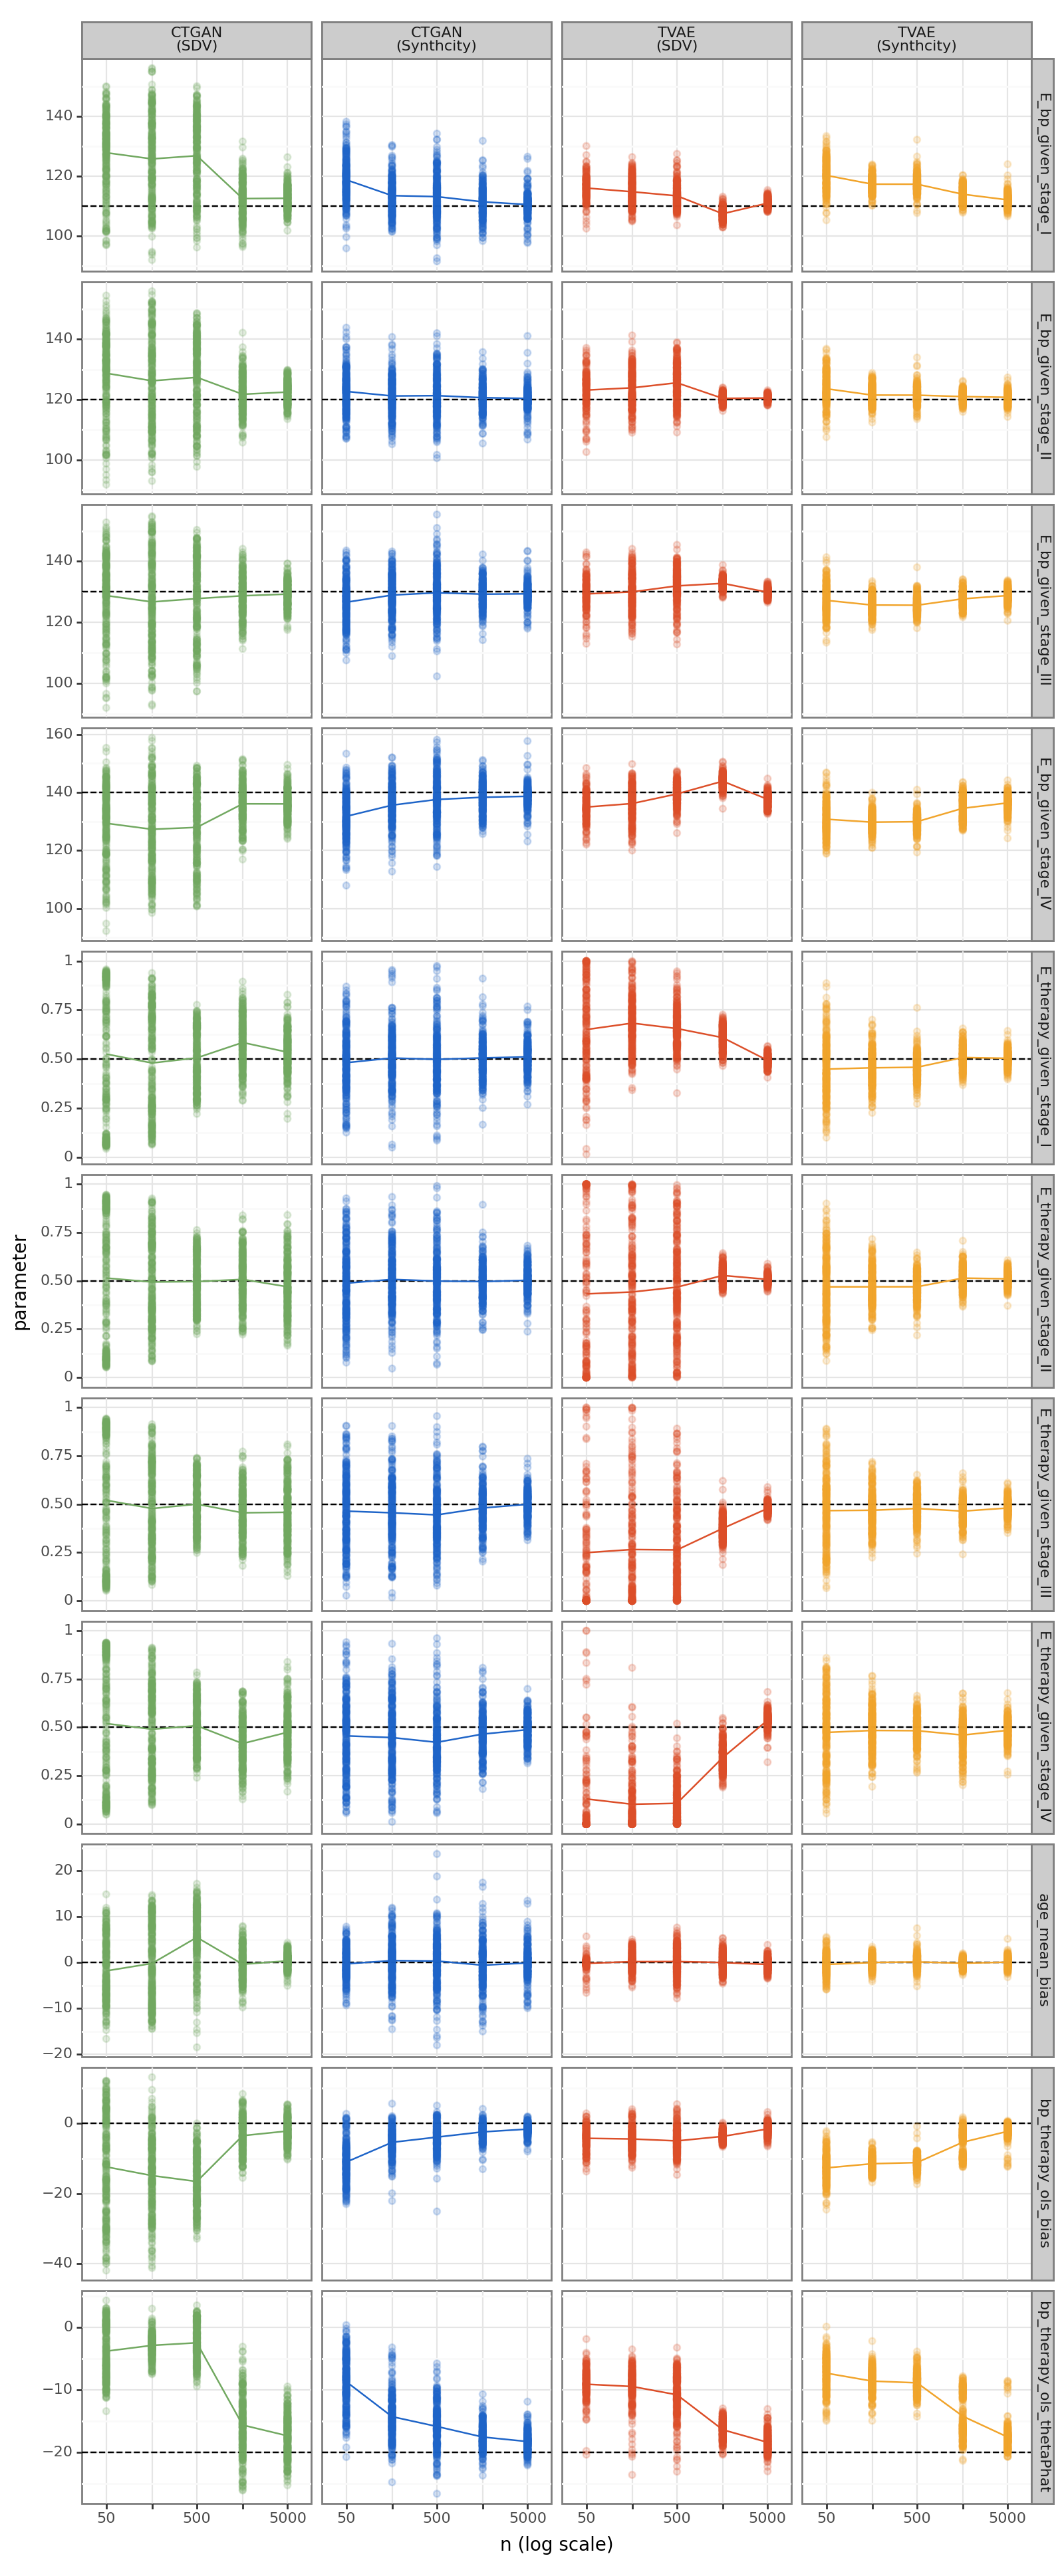

<Figure Size: (800 x 1937)>

In [53]:
# Ground truth
target_gt = {'age_mean_bias': 0,
             'bp_therapy_ols_bias': 0,
             'bp_therapy_ols_thetaPhat': -20,
             'E_bp_given_stage_I': 120 + 0.50*(-20), # 50% receives therapy
             'E_bp_given_stage_II': 120 + 10 + 0.50*(-20), # 50% receives therapy
             'E_bp_given_stage_III': 120 + 20 + 0.50*(-20), # 50% receives therapy
             'E_bp_given_stage_IV': 120 + 30 + 0.50*(-20), # 50% receives therapy
             'E_therapy_given_stage_I': 0.50,
             'E_therapy_given_stage_II': 0.50,
             'E_therapy_given_stage_III': 0.50,
             'E_therapy_given_stage_IV': 0.50}
# Relabel
relabel_generators = {'custom_ctgan': 'CTGAN\n(SDV)',
                      'ctgan': 'CTGAN\n(Synthcity)',
                      'custom_tvae': 'TVAE\n(SDV)',
                      'tvae': 'TVAE\n(Synthcity)'}

# Plot
plot_nuisance_parameters(meta_diagnostics,
                         order_generators=['custom_ctgan', 'ctgan', 'custom_tvae', 'tvae'],
                         ground_truth=target_gt) +\
    facet_grid('parameter ~ generator', scales='free', labeller=labeller(generator=lambda x: relabel_generators[x])) +\
    scale_x_continuous(limits=[35,7000], breaks=[50,160,500,1600,5000], labels=[50,'',500,'',5000], trans='log') +\
    theme(plot_title=element_blank(), # title size
          axis_title=element_text(size=10), # axis title size
          strip_text=element_text(size=8), # facet_grid title size
          strip_text_y=element_text(margin={'l': 3, 'r': 3, 'units': 'pt'}), # facet_grid margin
          axis_text=element_text(size=8)) # axis labels size 

Table (appendix)

In [54]:
# Calculate MSE of nuisance parameters if not previously done
for parameter in meta_diagnostics.drop(columns=['dataset_name', 'n', 'run', 'generator']).columns:
    if '_bias' not in parameter:
        meta_diagnostics[parameter + '_bias'] = (meta_diagnostics[parameter] - target_gt[parameter])

# Presets
order_columns = ['custom_ctgan', 'ctgan', 'custom_tvae', 'tvae']
order_columns = [('convergence rate', generator) for generator in order_columns]
select_rows = [column[:-len('_bias')] for column in meta_diagnostics.columns if '_bias' in column]

# Table MSE
conv_rate_MSE = table_convergence_rate(meta_diagnostics,
                                       intercept=True,
                                       metric='MSE',
                                       round_decimals=2,
                                       show_ci=True).pivot(index='estimator', columns='generator').loc[select_rows,order_columns]

# Table SE
conv_rate_se = table_convergence_rate(meta_diagnostics,
                                      intercept=True,
                                      metric='se',
                                      round_decimals=2,
                                      show_ci=True).pivot(index='estimator', columns='generator').loc[select_rows,order_columns]

# Table bias
conv_rate_bias = table_convergence_rate(meta_diagnostics,
                                        intercept=True,
                                        metric='bias',
                                        round_decimals=2,
                                        show_ci=True).pivot(index='estimator', columns='generator').loc[select_rows,order_columns]


# Display combined tables MSE/SE/bias
pd.set_option('display.max_colwidth', None) # display the maximum width of each single field.
conv_rate_MSE.combine(conv_rate_se, lambda s1, s2: s1 + ' / ' + s2).combine(conv_rate_bias, lambda s1, s2: s1 + ' / ' + s2)

convergence rate  \
generator                                                                   custom_ctgan   
estimator                                                                                  
age_mean                     0.33 [-0.03; 0.69] / 0.33 [0.03; 0.63] / 0.24 [-0.91; 1.38]   
bp_therapy_ols                0.37 [0.09; 0.66] / 0.33 [0.29; 0.37] / 0.42 [-0.02; 0.87]   
bp_therapy_ols_thetaPhat     0.33 [0.04; 0.61] / -0.04 [-0.39; 0.30] / 0.43 [0.06; 0.81]   
E_bp_given_stage_I             0.37 [0.08; 0.66] / 0.28 [0.04; 0.52] / 0.49 [0.05; 0.94]   
E_therapy_given_stage_I      0.24 [0.12; 0.36] / 0.27 [0.17; 0.37] / -0.18 [-0.97; 0.61]   
E_bp_given_stage_II           0.30 [0.08; 0.53] / 0.30 [0.06; 0.55] / 0.33 [-0.01; 0.67]   
E_therapy_given_stage_II    0.19 [-0.01; 0.38] / 0.19 [0.00; 0.38] / -0.15 [-0.86; 0.55]   
E_bp_given_stage_IV           0.26 [0.02; 0.49] / 0.25 [0.04; 0.46] / 0.27 [-0.02; 0.57]   
E_therapy_given_stage_IV     0.19 [0.01; 0.38] / 0.21 [0.03; 0.40] / -0.23 [-0.95; 0.49]   
E_bp_given_stage_III          0.27 [0.04; 0.51] / 0.28 [0.04; 0.51] / 0.17 [-0.27; 0.60]   
E_therapy_given_stage_III  0.18 [-0.03; 0.40] / 0.19 [-0.02; 0.41] / -0.19 [-2.51; 2.14]   

                                                                                           \
generator                                                                           ctgan   
estimator                                                                                   
age_mean                   -0.02 [-0.23; 0.19] / -0.02 [-0.23; 0.19] / 0.17 [-0.39; 0.73]   
bp_therapy_ols                  0.35 [0.28; 0.43] / 0.26 [0.16; 0.36] / 0.40 [0.32; 0.48]   
bp_therapy_ols_thetaPhat        0.35 [0.28; 0.43] / 0.23 [0.10; 0.35] / 0.40 [0.32; 0.48]   
E_bp_given_stage_I             0.21 [0.06; 0.35] / 0.11 [-0.04; 0.26] / 0.56 [0.36; 0.76]   
E_therapy_given_stage_I        0.16 [0.02; 0.30] / 0.16 [0.02; 0.31] / 0.08 [-0.73; 0.90]   
E_bp_given_stage_II            0.14 [0.01; 0.27] / 0.13 [-0.01; 0.26] / 0.41 [0.23; 0.59]   
E_therapy_given_stage_II       0.22 [0.08; 0.36] / 0.22 [0.08; 0.36] / 0.30 [-0.47; 1.07]   
E_bp_given_stage_IV            0.21 [0.10; 0.33] / 0.14 [-0.02; 0.31] / 0.40 [0.27; 0.52]   
E_therapy_given_stage_IV       0.23 [0.08; 0.38] / 0.23 [0.11; 0.35] / 0.26 [-0.19; 0.72]   
E_bp_given_stage_III          0.17 [0.03; 0.32] / 0.16 [-0.00; 0.32] / 0.32 [-0.28; 0.92]   
E_therapy_given_stage_III      0.22 [0.08; 0.36] / 0.22 [0.09; 0.34] / 0.78 [-0.30; 1.86]   

                                                                                         \
generator                                                                   custom_tvae   
estimator                                                                                 
age_mean                   0.00 [-0.29; 0.30] / 0.01 [-0.30; 0.31] / 0.11 [-1.14; 1.35]   
bp_therapy_ols             0.17 [-0.04; 0.38] / 0.19 [-0.05; 0.43] / 0.18 [-0.09; 0.45]   
bp_therapy_ols_thetaPhat     0.37 [0.12; 0.62] / 0.14 [-0.13; 0.40] / 0.43 [0.13; 0.72]   
E_bp_given_stage_I            0.31 [0.16; 0.46] / 0.25 [0.06; 0.45] / 0.37 [0.19; 0.55]   
E_therapy_given_stage_I      0.46 [0.08; 0.84] / 0.46 [0.35; 0.57] / 0.58 [-0.21; 1.37]   
E_bp_given_stage_II          0.49 [0.03; 0.95] / 0.49 [0.11; 0.87] / 0.52 [-0.19; 1.24]   
E_therapy_given_stage_II      0.64 [0.25; 1.04] / 0.67 [0.25; 1.09] / 0.43 [0.17; 0.70]   
E_bp_given_stage_IV          0.17 [0.02; 0.33] / 0.23 [0.08; 0.38] / 0.13 [-0.63; 0.89]   
E_therapy_given_stage_IV      0.44 [0.07; 0.82] / 0.37 [0.31; 0.43] / 0.48 [0.01; 0.95]   
E_bp_given_stage_III       0.31 [-0.01; 0.63] / 0.37 [0.05; 0.69] / -0.24 [-2.45; 1.97]   
E_therapy_given_stage_III    0.51 [0.09; 0.94] / 0.57 [0.20; 0.95] / 0.48 [-0.02; 0.97]   

                                                                                          
generator                                                                           tvae  
estimator              

**Difference between P_tilde_m and P_hat_n should converge to zero in L2**

Plot (not presented in paper)

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_summary : Removed 1046 rows containing non-finite values.
/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1046 rows containing missing values.


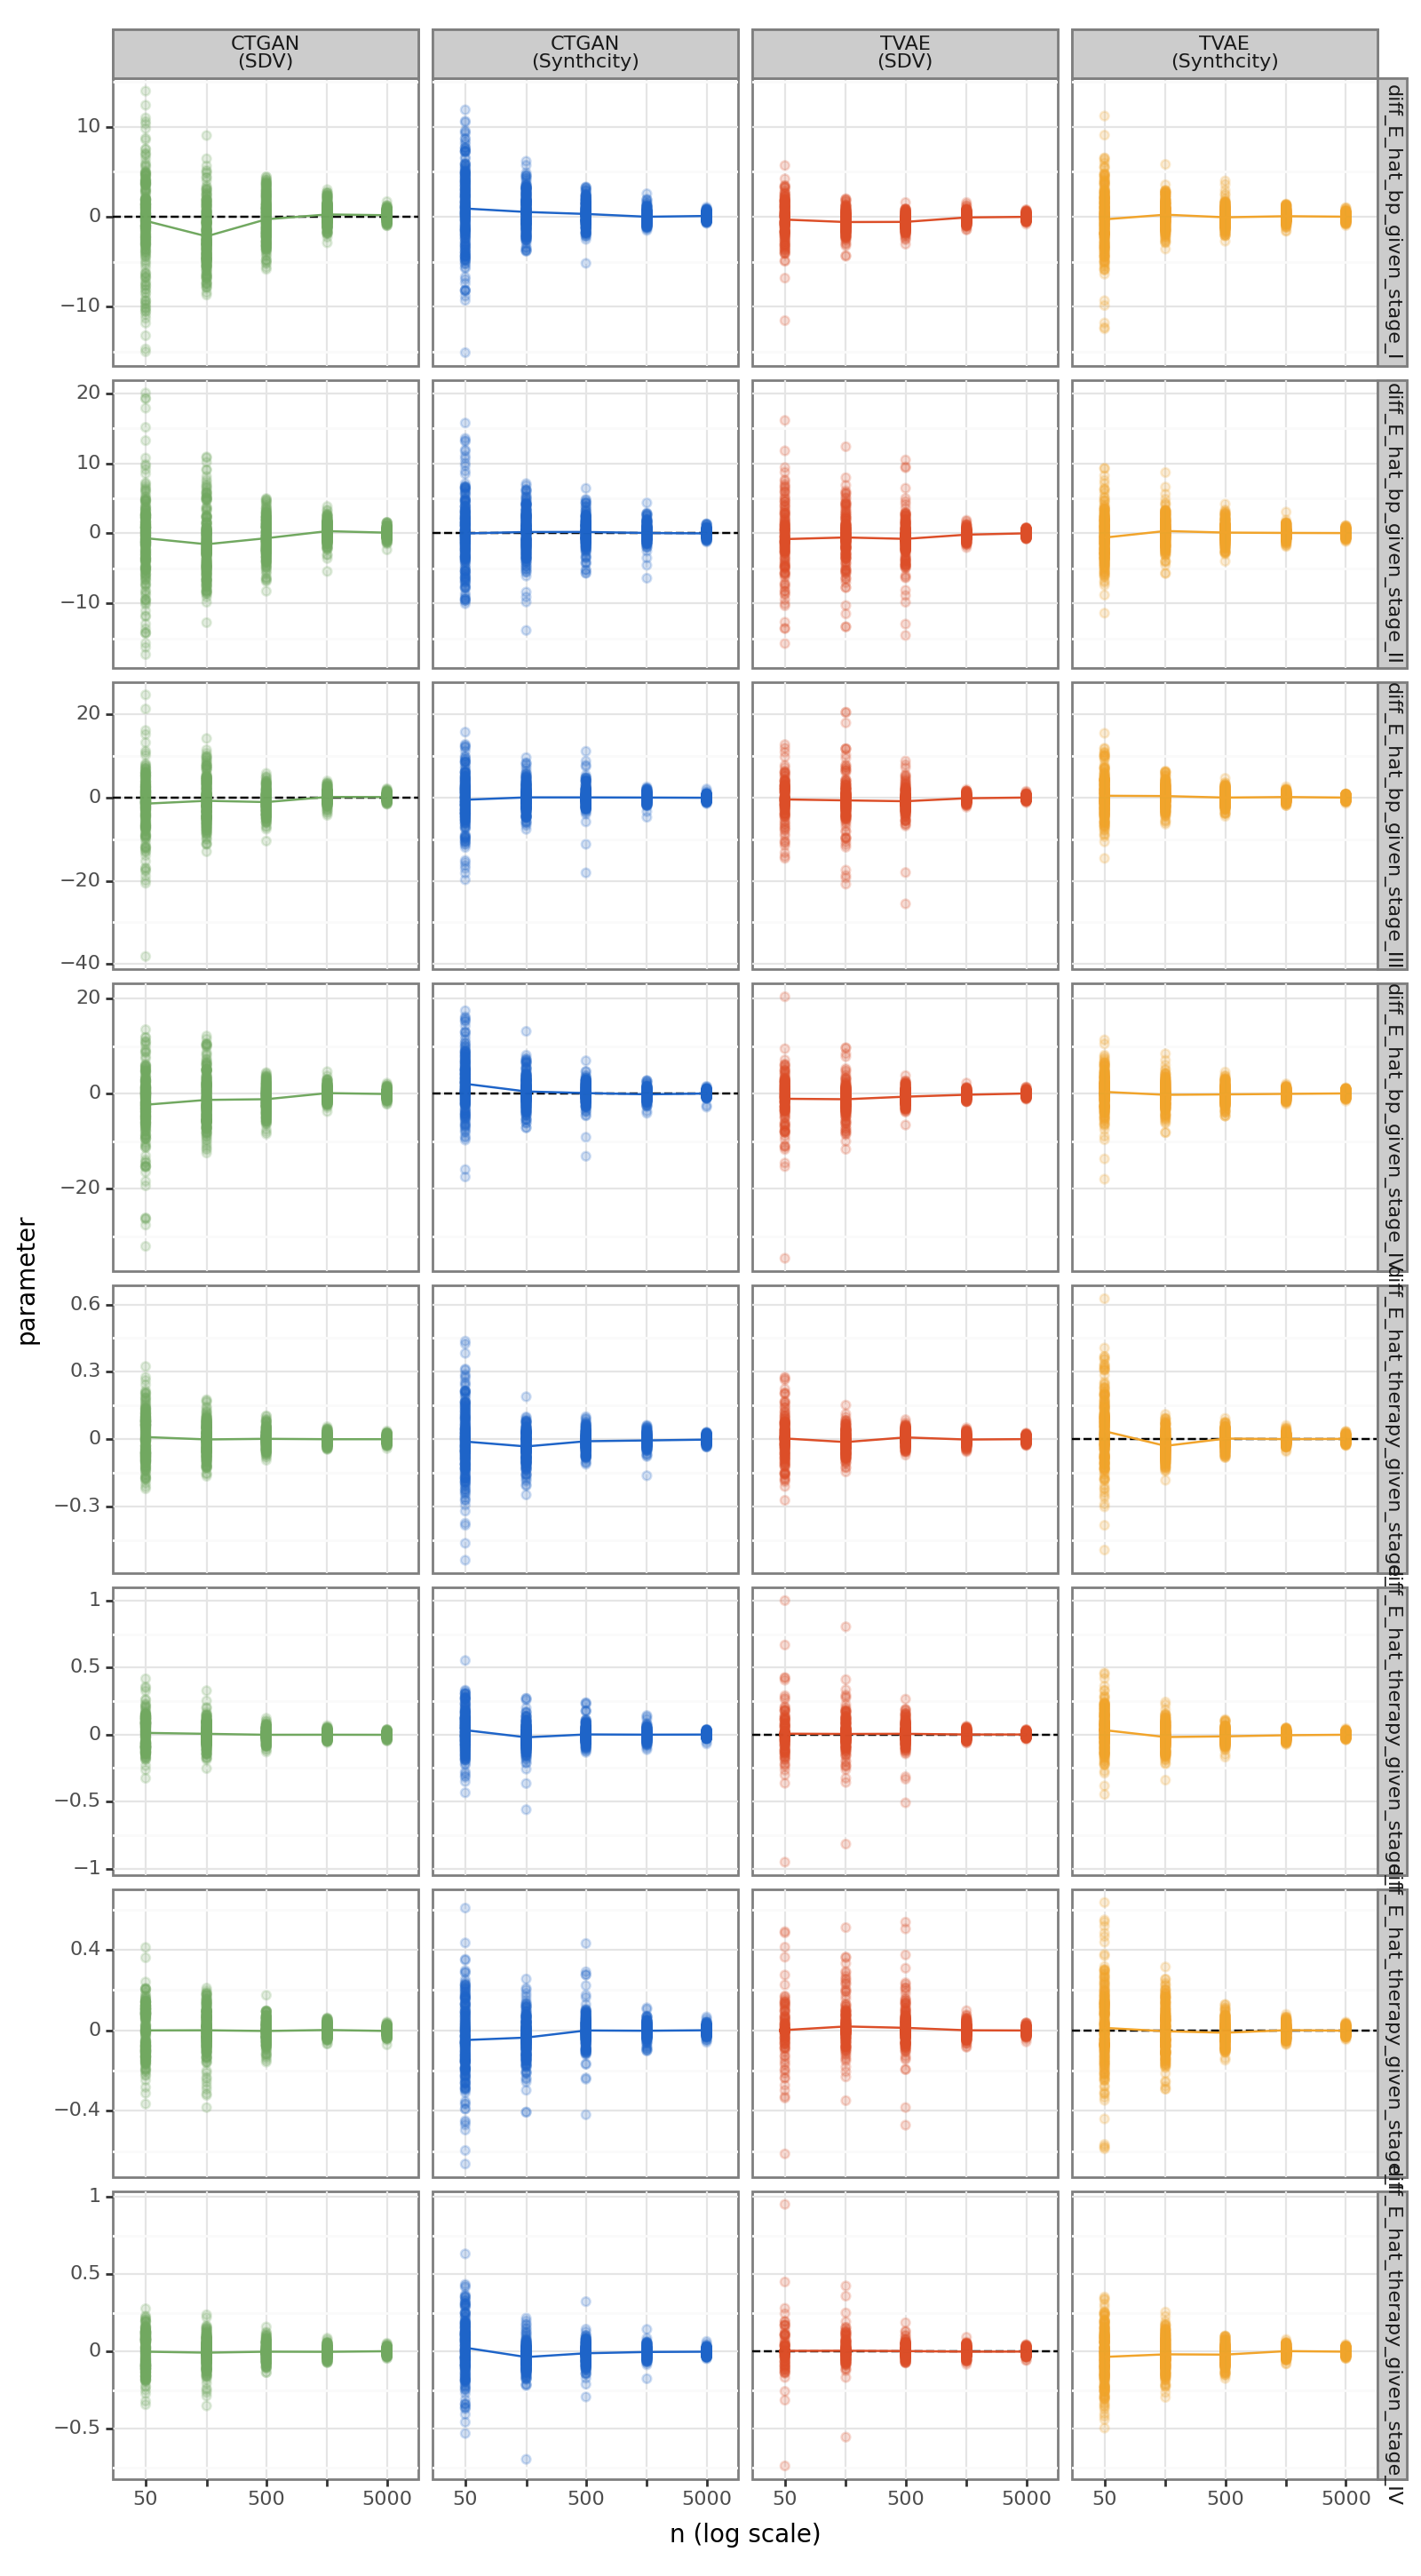

<Figure Size: (800 x 1450)>

In [55]:
# Ground truth
target_gt2 = {'diff_E_hat_bp_given_stage_I': 0,
              'diff_E_hat_bp_given_stage_II': 0,
              'diff_E_hat_bp_given_stage_III': 0, 
              'diff_E_hat_bp_given_stage_IV': 0,
              'diff_E_hat_therapy_given_stage_I': 0,
              'diff_E_hat_therapy_given_stage_II': 0,
              'diff_E_hat_therapy_given_stage_III': 0,
              'diff_E_hat_therapy_given_stage_IV': 0}

# Relabel
relabel_generators = {'custom_ctgan': 'CTGAN\n(SDV)',
                      'ctgan': 'CTGAN\n(Synthcity)',
                      'custom_tvae': 'TVAE\n(SDV)',
                      'tvae': 'TVAE\n(Synthcity)'}

# Plot
plot_nuisance_parameters(meta_diagnostics2,
                         order_generators=['custom_ctgan', 'ctgan', 'custom_tvae', 'tvae'],
                         ground_truth=target_gt2) +\
    facet_grid('parameter ~ generator', scales='free', labeller=labeller(generator=lambda x: relabel_generators[x])) +\
    scale_x_continuous(limits=[35,7000], breaks=[50,160,500,1600,5000], labels=[50,'',500,'',5000], trans='log') +\
    theme(plot_title=element_blank(), # title size
          axis_title=element_text(size=10), # axis title size
          strip_text=element_text(size=8), # facet_grid title size
          strip_text_y=element_text(margin={'l': 3, 'r': 3, 'units': 'pt'}), # facet_grid margin
          axis_text=element_text(size=8)) # axis labels size 

Table (appendix)

In [56]:
# Calculate bias of nuisance parameters if not previously done
for parameter in meta_diagnostics2.drop(columns=['dataset_name', 'n', 'run', 'generator']).columns:
    if '_bias' not in parameter:
        meta_diagnostics2[parameter + '_bias'] = meta_diagnostics2[parameter] # already difference
        
# Presets
order_columns = ['custom_ctgan', 'ctgan', 'custom_tvae', 'tvae']
order_columns = [('convergence rate', generator) for generator in order_columns]
select_rows = [column[:-len('_bias')] for column in meta_diagnostics2.columns if '_bias' in column]

# Table MSE
conv_rate_MSE = table_convergence_rate(meta_diagnostics2,
                                       intercept=True,
                                       metric='MSE',
                                       round_decimals=2,
                                       show_ci=True).pivot(index='estimator', columns='generator').loc[select_rows,order_columns]

# Table SE
conv_rate_se = table_convergence_rate(meta_diagnostics2,
                                      intercept=True,
                                      metric='se',
                                      round_decimals=2,
                                      show_ci=True).pivot(index='estimator', columns='generator').loc[select_rows,order_columns]

# Table bias
conv_rate_bias = table_convergence_rate(meta_diagnostics2,
                                        intercept=True,
                                        metric='bias',
                                        round_decimals=2,
                                        show_ci=True).pivot(index='estimator', columns='generator').loc[select_rows,order_columns]


# Display combined tables MSE/SE/bias
pd.set_option('display.max_colwidth', None) # display the maximum width of each single field.
conv_rate_MSE.combine(conv_rate_se, lambda s1, s2: s1 + ' / ' + s2).combine(conv_rate_bias, lambda s1, s2: s1 + ' / ' + s2)

convergence rate  \
generator                                                                          custom_ctgan   
estimator                                                                                         
diff_E_hat_bp_given_stage_I          0.50 [0.34; 0.66] / 0.50 [0.35; 0.65] / 0.37 [-0.29; 1.03]   
diff_E_hat_therapy_given_stage_I      0.47 [0.41; 0.52] / 0.47 [0.41; 0.52] / 0.50 [0.08; 0.93]   
diff_E_hat_bp_given_stage_II         0.50 [0.35; 0.64] / 0.49 [0.36; 0.62] / 0.49 [-0.03; 1.01]   
diff_E_hat_therapy_given_stage_II     0.46 [0.40; 0.52] / 0.46 [0.40; 0.52] / 0.46 [0.05; 0.88]   
diff_E_hat_bp_given_stage_III         0.52 [0.41; 0.63] / 0.52 [0.42; 0.63] / 0.56 [0.12; 0.99]   
diff_E_hat_therapy_given_stage_III  0.46 [0.35; 0.57] / 0.47 [0.36; 0.58] / -0.54 [-1.15; 0.08]   
diff_E_hat_bp_given_stage_IV          0.51 [0.42; 0.61] / 0.50 [0.41; 0.59] / 0.83 [0.38; 1.27]   
diff_E_hat_therapy_given_stage_IV    0.43 [0.37; 0.50] / 0.43 [0.37; 0.50] / 0.16 [-0.44; 0.76]   

                                                                                                \
generator                                                                                ctgan   
estimator                                                                                        
diff_E_hat_bp_given_stage_I         0.53 [0.48; 0.58] / 0.53 [0.47; 0.58] / 0.81 [-0.40; 2.02]   
diff_E_hat_therapy_given_stage_I    0.50 [0.44; 0.56] / 0.49 [0.40; 0.58] / 0.41 [-0.10; 0.92]   
diff_E_hat_bp_given_stage_II        0.48 [0.36; 0.60] / 0.48 [0.36; 0.60] / 0.22 [-1.01; 1.44]   
diff_E_hat_therapy_given_stage_II    0.46 [0.37; 0.55] / 0.45 [0.36; 0.54] / 1.45 [0.81; 2.10]   
diff_E_hat_bp_given_stage_III       0.51 [0.35; 0.67] / 0.51 [0.35; 0.67] / 0.60 [-0.14; 1.35]   
diff_E_hat_therapy_given_stage_III   0.49 [0.37; 0.61] / 0.48 [0.35; 0.61] / 1.06 [0.13; 1.99]   
diff_E_hat_bp_given_stage_IV         0.50 [0.44; 0.55] / 0.48 [0.42; 0.54] / 0.78 [0.44; 1.13]   
diff_E_hat_therapy_given_stage_IV    0.48 [0.42; 0.54] / 0.47 [0.40; 0.55] / 0.64 [0.24; 1.04]   

                                                                                                \
generator                                                                          custom_tvae   
estimator                                                                                        
diff_E_hat_bp_given_stage_I         0.43 [0.35; 0.50] / 0.41 [0.33; 0.50] / 0.68 [-0.10; 1.46]   
diff_E_hat_therapy_given_stage_I    0.45 [0.39; 0.50] / 0.44 [0.38; 0.51] / 0.47 [-0.42; 1.36]   
diff_E_hat_bp_given_stage_II        0.60 [0.30; 0.89] / 0.60 [0.31; 0.89] / 1.33 [-0.27; 2.93]   
diff_E_hat_therapy_given_stage_II    0.58 [0.39; 0.78] / 0.58 [0.39; 0.78] / 0.65 [0.09; 1.21]   
diff_E_hat_bp_given_stage_III       0.59 [0.24; 0.95] / 0.59 [0.25; 0.94] / 0.73 [-0.20; 1.65]   
diff_E_hat_therapy_given_stage_III  0.49 [0.21; 0.77] / 0.49 [0.21; 0.76] / 0.49 [-0.98; 1.95]   
diff_E_hat_bp_given_stage_IV         0.56 [0.49; 0.63] / 0.56 [0.49; 0.63] / 0.68 [0.26; 1.10]   
diff_E_hat_therapy_given_stage_IV    0.42 [0.32; 0.53] / 0.43 [0.32; 0.53] / 0.31 [0.12; 0.51]   

                                                                                                
generator                                                                                 tvae  
estimator                                                                                       
diff_E_hat_bp_given_stage_I          0.47 [0.36; 0.57] / 0.47 [0.36; 0.58] / 1.17 [0.14; 2.19]  
diff_E_hat_therapy_given_stage_I     0.54 [0.44; 0.63] / 0.52 [0.39; 0.65] / 1.08 [0.27; 1.88]  
diff_E_hat_bp_given_stage_II         0.44 [0.40; 0.48] / 0.43 [0.39; 0.47] / 0.64 [0.49; 0.80]  
diff_E_hat_therapy_given_stage_II    0.50 [0.45; 0.54] / 0.49 [0.44; 0.54] / 0.67 [0.40; 0.94]  
diff_E_hat_bp_given_stage_III       0.50 [0.45; 0.56] / 0.50 [0.44; 0.56] / 1.04 [-0.43; 2.51]  
diff_E_hat_therapy_given_stage_III  0.55 [0.52; 0.58] /

## Type 1 error and power

**Plots (not presented in paper)**

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'color' is already present.
Adding another scale for 'color',
which will replace the existing scale.

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'linetype' is already present.
Adding another scale for 'linetype',
which will replace the existing scale.

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_text : Removed 2 rows containing missing values.


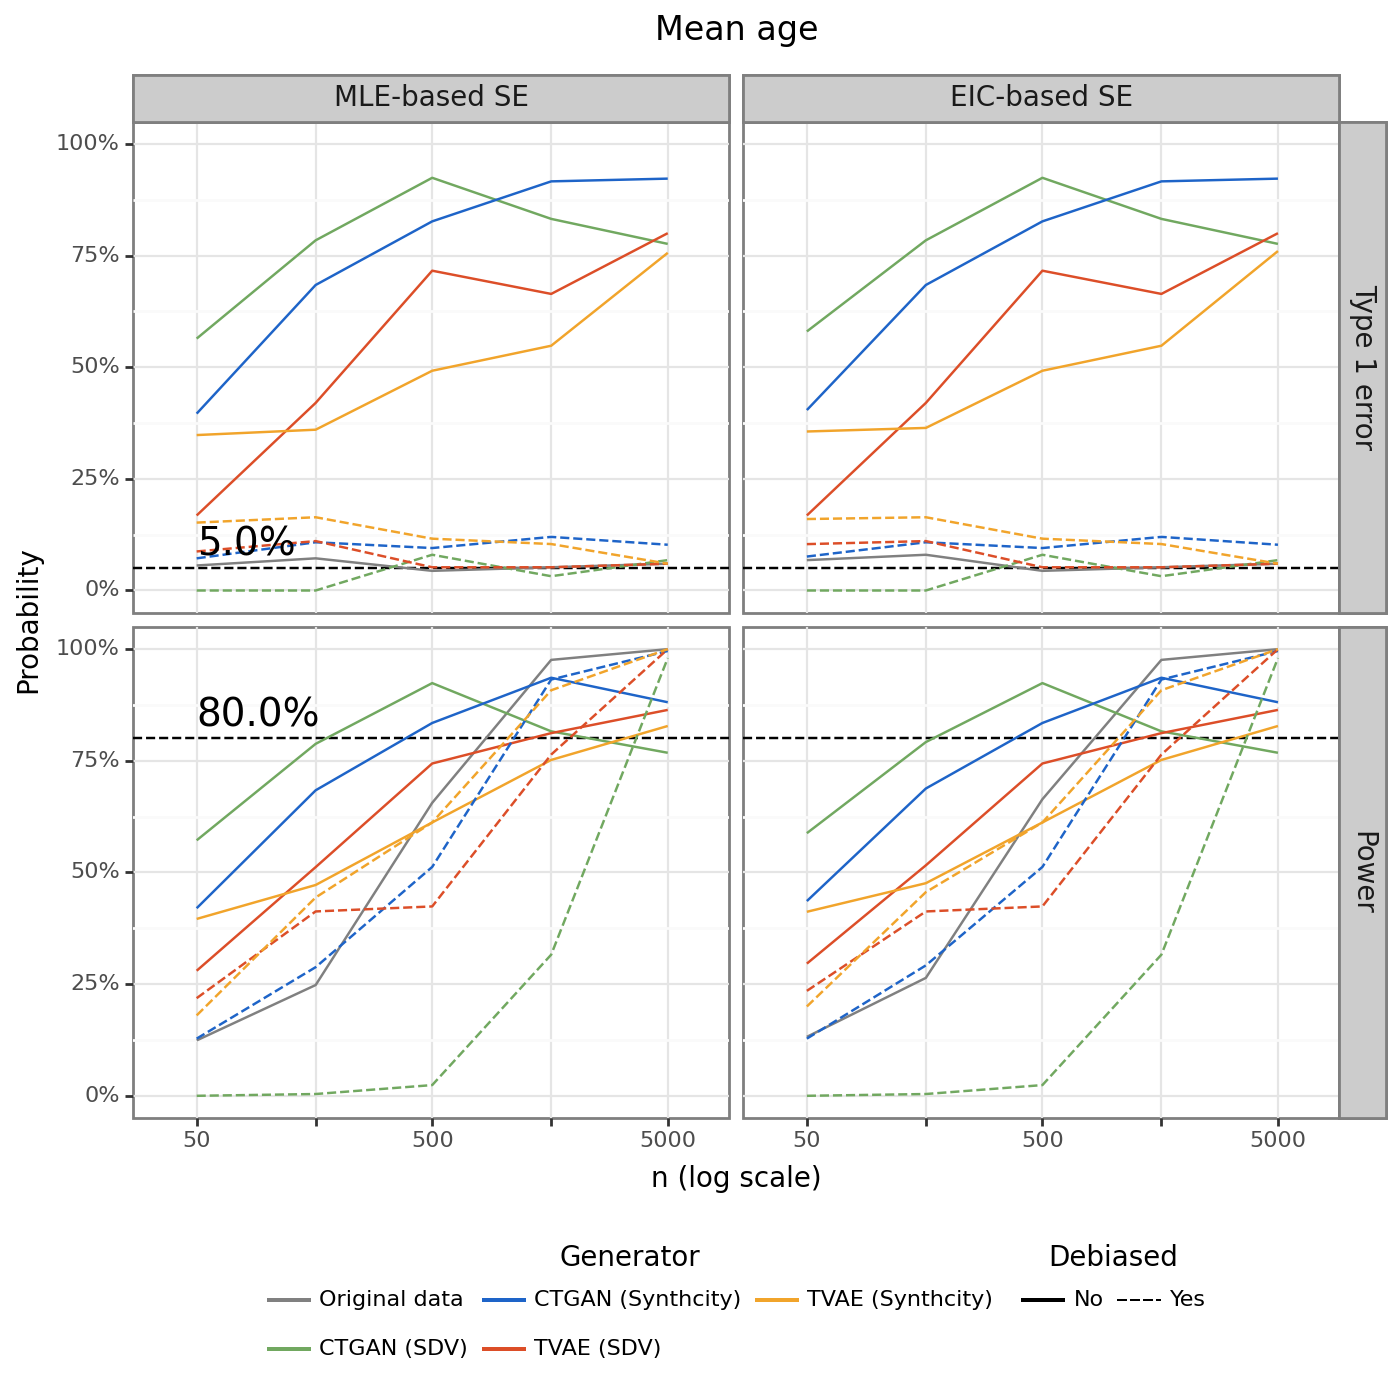

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'color' is already present.
Adding another scale for 'color',
which will replace the existing scale.

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'linetype' is already present.
Adding another scale for 'linetype',
which will replace the existing scale.

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_text : Removed 2 rows containing missing values.


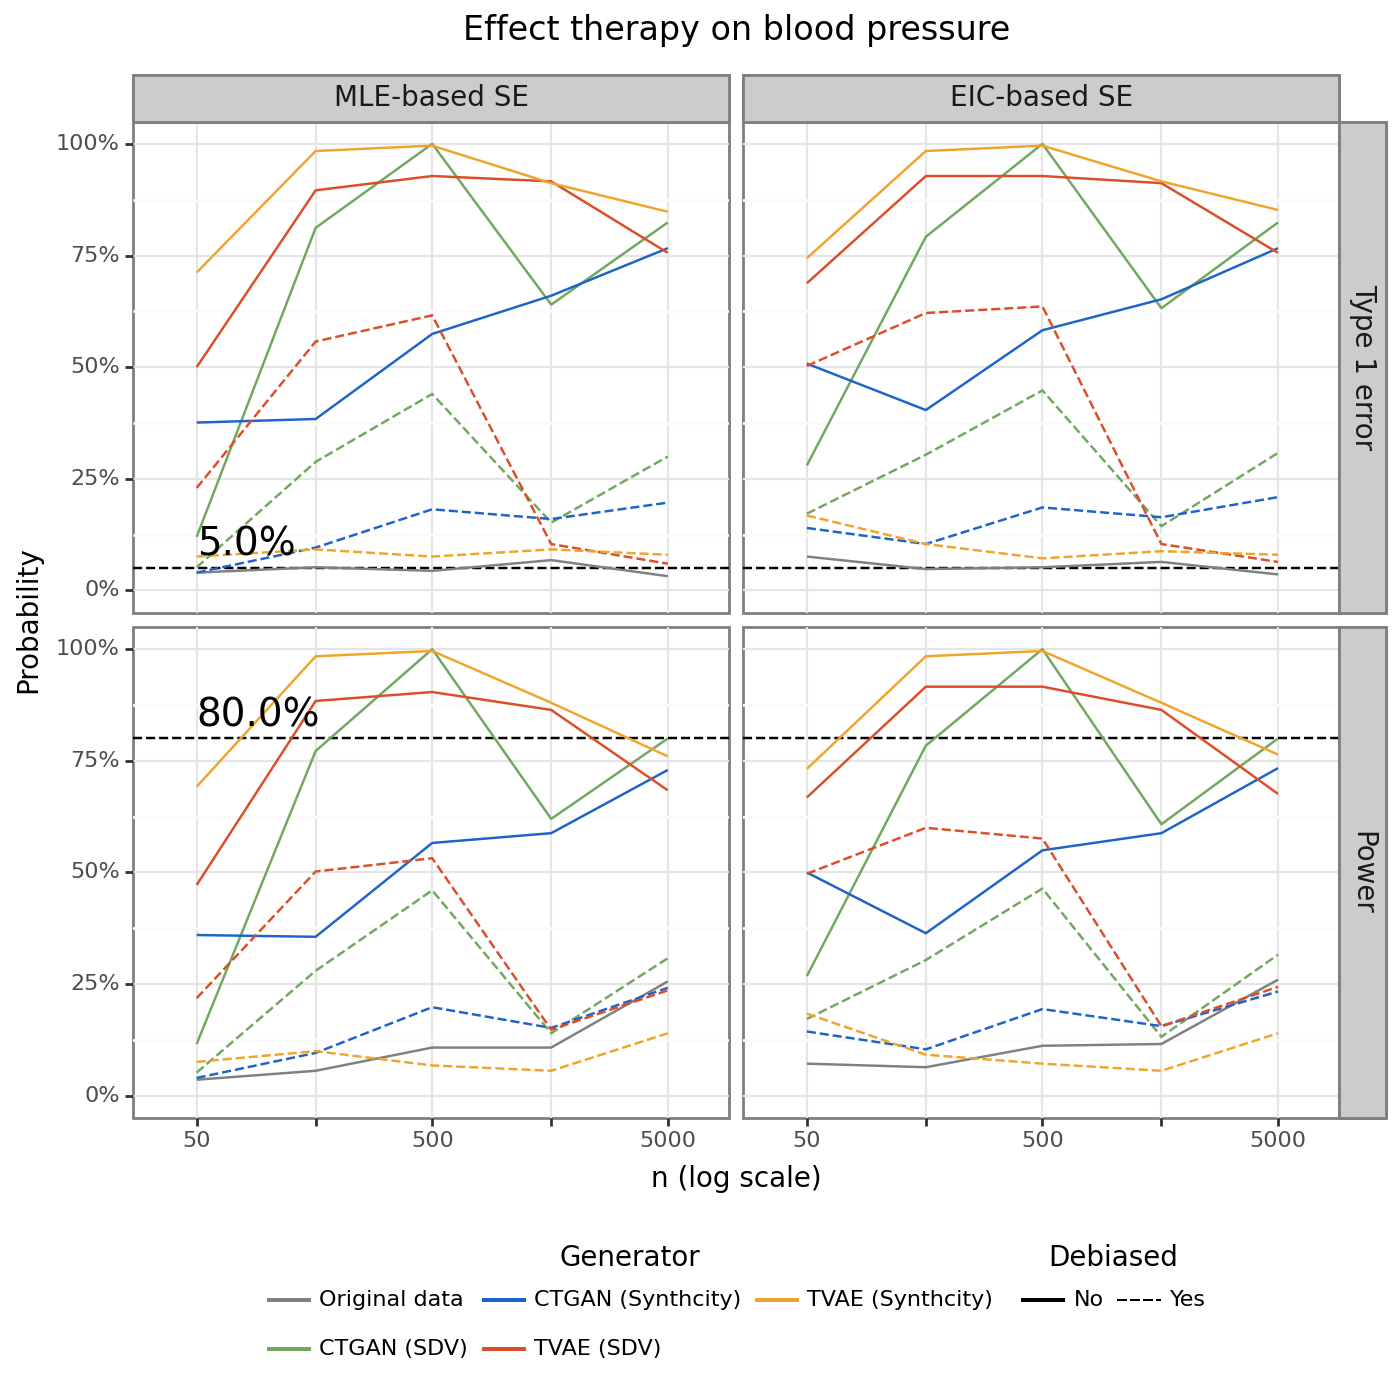

In [57]:
# Presets
select_estimators = ['age_mean', 'bp_therapy_ols']

# Plot data
plots = plot_type_I_II_error(meta_data, 
                             select_estimators=select_estimators,
                             order_generators=['original', 'custom_ctgan', 'ctgan', 'custom_tvae', 'tvae'],
                             use_power=True,
                             figure_size=(7,7))

# Add text to vertical intercepts
intercepts_text = pd.DataFrame({'error': ['type 1 error', 'type 1 error', 'power', 'power'], 
                                'type_se': ['model_based', 'ic', 'model_based', 'ic'], 
                                'intercept': [0.05, np.nan, 0.80, np.nan], 
                                'generator_class': ['original']*4,
                                'targeted': ['default']*4}) 
intercepts_text['label'] = intercepts_text.apply(lambda i: str(i['intercept']*100) + '%', axis=1)
intercepts_text['type_se'] = pd.Categorical(intercepts_text['type_se'], categories=['model_based', 'ic']) # change order (non-alphabetically)
intercepts_text['error'] = pd.Categorical(intercepts_text['error'], categories=['type 1 error', 'power']) # change order (non-alphabetically)

# Relabel
relabel_error = {'type 1 error': 'Type 1 error',
                 'power': 'Power'}
relabel_SE = {'model_based': 'MLE-based SE',
              'ic': 'EIC-based SE'}
relabel_estimators = {'age_mean': 'Mean age',
                      'bp_therapy_ols': 'Effect therapy on blood pressure'}

# Plot
for estimator,plot in zip(select_estimators,plots):
    updated_plot = plot +\
        facet_grid('error ~ type_se', labeller=labeller(error=lambda x:relabel_error[x], type_se=lambda x:relabel_SE[x])) +\
        geom_text(data=intercepts_text, mapping=aes(x=50, y='intercept.astype(float)+0.01', label='label'), ha='left', va='bottom', colour='black', size=14) +\
        labs(color='Generator', linetype='Debiased', y='Probability', title=relabel_estimators[estimator]) +\
        scale_x_continuous(limits=[35,7000], breaks=[50,160,500,1600,5000], labels=[50,'',500,'',5000], trans='log') +\
    scale_colour_manual(values={'original': '#808080', 'custom_ctgan': '#71A860', 'ctgan': '#1E64C8', 'custom_tvae': '#DC4E28', 'tvae': '#F1A42B'}, # relabel legend                                                 
                        labels=['Original data', 'CTGAN (SDV)', 'CTGAN (Synthcity)', 'TVAE (SDV)', 'TVAE (Synthcity)']) +\
    scale_linetype_manual(values={'default': 'solid', 'targeted': 'dashed'}, # relabel legend  
                          labels=['No', 'Yes']) +\
        guides(colour=guide_legend(nrow=2)) +\
        theme(plot_title=element_text(size=12), # title size
              axis_title=element_text(size=10), # axis title size
              strip_text=element_text(size=10), # facet_grid title size
              axis_text=element_text(size=8), # axis labels size
              legend_position='bottom',
              legend_title=element_text(size=10), # legend title size
              legend_title_align='center',
              legend_text=element_text(size=8), # legend labels size 
              legend_key=element_blank())
    print(updated_plot)

# Sanity check: common rows

**Table (appendix)**

In [58]:
meta_data.query('sanity_common_rows_proportion != 0 & generator != \'original\'')[['dataset_name', 'n', 'run', 'generator', 'sanity_common_rows_proportion']].sort_values(by=['generator', 'n'])

dataset_name   n      run generator  sanity_common_rows_proportion
811       ctgan_0  50   run_92     ctgan                           0.02
1376      ctgan_0  50  run_157     ctgan                           0.02
1672      ctgan_0  50  run_191     ctgan                           0.02